In [64]:
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm


In [2]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)
plt.rcParams['text.latex.preamble']=r'\usepackage{amsmath,amssymb,physics,bm}'

In [122]:
%load_ext line_profiler

In [281]:
from importlib import reload

import GTN2
reload(GTN2)
from GTN2 import *

In [4]:
from importlib import reload

import utils
reload(utils)
from utils import *

# Test

In [5]:
def measure_feedback_layer(gtn2,margin=0):
    ij_list = [(i,j) for i in range(margin,gtn2.Lx-margin) for j in range(margin,gtn2.Ly-margin)]
    for i,j in tqdm(ij_list):
        gtn2.measure_feedback(ij = [i,j])

In [6]:
def randomize(gtn2):
    for i in tqdm(range(2*gtn2.L+1,4*gtn2.L,2)):
        # print([i, (i+1)%(4*gtn2.L)])
        gtn2.randomize([i, (i+1)%(4*gtn2.L)])

In [7]:
def convert_to_list(a_i):
    i_list=[]
    j_list=[]
    a_list=[]
    for key,value in a_i.items():
        i_list.append(key[0])
        j_list.append(key[1])
        a_list.append(value)
    a_list=np.array(a_list)
    i_list=np.array(i_list)
    j_list=np.array(j_list)
    return i_list,j_list,a_list


In [8]:
def place_color_bar_top(im,ax,label):
    axins=ax.inset_axes([0.,1.1,1,0.1])
    cb=plt.colorbar(im,cax=axins,orientation='horizontal')
    cb.set_label(label,)
    cb.set_ticks([-np.pi,0,np.pi],labels=[r'$-\pi$',r'$0$',r'$\pi$'])
    cb.ax.xaxis.set_ticks_position('top')

In [9]:
def plot_chern(nu_list,log=False,C=0,ax=None,label=None,color=None):
    if ax is None:
        fig,ax=plt.subplots()
    if log:
        ax.plot(1+np.arange(len(nu_list)),np.abs(np.abs(np.array(nu_list))-C),'.-',label=label,color=color)
    else:
        ax.plot(np.arange(len(nu_list)),(np.array(nu_list)),'.-',label=label,color=color)

    # ax.set_xlabel('steps')
    ax.set_xlabel('epoch')
    if log:
        ax.set_ylabel(rf'$\abs{{\abs{{\mathcal{{C}}}}-{C}}}$')
        ax.set_yscale('log')
        ax.set_xscale('log')
    else:
        ax.set_ylabel(r'${\mathcal{C}}$')
    # ax.set_ylim(-2,None)

## C=0 -> C=1

In [62]:
gtn2=GTN2(Lx=18,Ly=18,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=4,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=1.8)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=1.8)

Text(0, 0.5, '$j$')

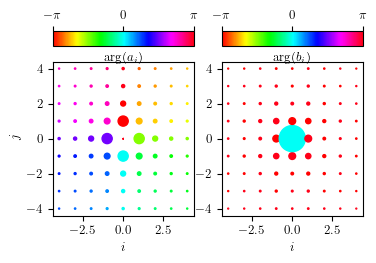

In [63]:
fig,ax=plt.subplots(1,2,figsize=(4,2))

i_list,j_list,a_list=convert_to_list(gtn2.a_i)
im=ax[0].scatter(i_list,j_list,s=400*np.abs(a_list),c=np.angle(a_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

i_list,j_list,b_list=convert_to_list(gtn2.b_i)
im=ax[1].scatter(i_list,j_list,s=400*np.abs(b_list),c=np.angle(b_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

place_color_bar_top(im,ax[0],r'$\arg(a_i)$')
place_color_bar_top(im,ax[1],r'$\arg(b_i)$')

[ax.set_xlabel('$i$') for ax in ax]
ax[0].set_ylabel('$j$')

# fig.savefig('mu1_nshell4.pdf',bbox_inches='tight')



In [13]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [14]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
measure_feedback_layer()
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
for i in range(10):
    randomize()
    measure_feedback_layer()
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))


100%|██████████| 225/225 [00:22<00:00, 10.22it/s]


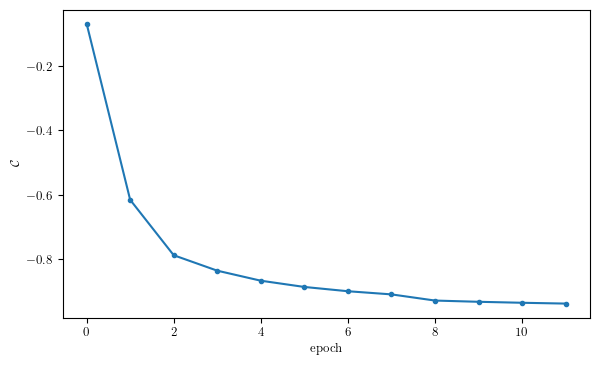

In [15]:
plot_chern(nu_list)

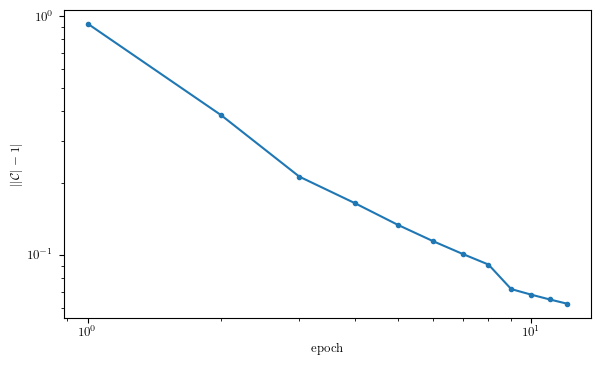

In [16]:
plot_chern(nu_list,log=True,C=1)

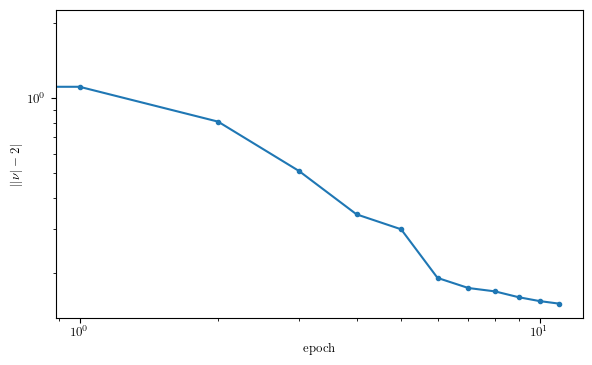

In [68]:
fig,ax=plt.subplots()
ax.plot(np.arange(len(nu_list)),np.array(nu_list)/2+1,'.-')
# ax.set_xlabel('steps')
ax.set_xlabel('epoch')
ax.set_ylabel(r'$\abs{\abs{\nu}-1}$')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-2,None)

## C=1 -> 0

In [18]:
gtn2=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=4,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=2.1)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=2.1)

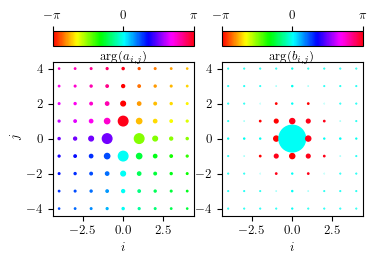

In [19]:
fig,ax=plt.subplots(1,2,figsize=(4,2))

i_list,j_list,a_list=convert_to_list(gtn2.a_i)
im=ax[0].scatter(i_list,j_list,s=400*np.abs(a_list),c=np.angle(a_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

i_list,j_list,b_list=convert_to_list(gtn2.b_i)
im=ax[1].scatter(i_list,j_list,s=400*np.abs(b_list),c=np.angle(b_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

place_color_bar_top(im,ax[0],r'$\arg(a_{i,j})$')
place_color_bar_top(im,ax[1],r'$\arg(b_{i,j})$')

[ax.set_xlabel('$i$') for ax in ax]
ax[0].set_ylabel('$j$')

fig.savefig('mu2p1_nshell4.pdf',bbox_inches='tight')



In [37]:
with open('C_m_15.pickle','rb') as f:
    C_m=pickle.load(f)
gtn2.C_m[:2*gtn2.L,:2*gtn2.L]=C_m
gtn2.C_m_history[0]=gtn2.C_m.copy()

In [38]:
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [39]:
chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)

-0.9995557038379123

In [40]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [41]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
measure_feedback_layer()
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
for i in range(10):
    randomize()
    measure_feedback_layer()
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:24<00:00,  9.19it/s]


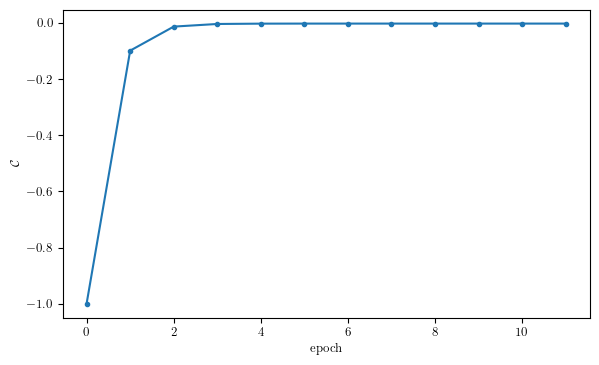

In [42]:
plot_chern(nu_list)

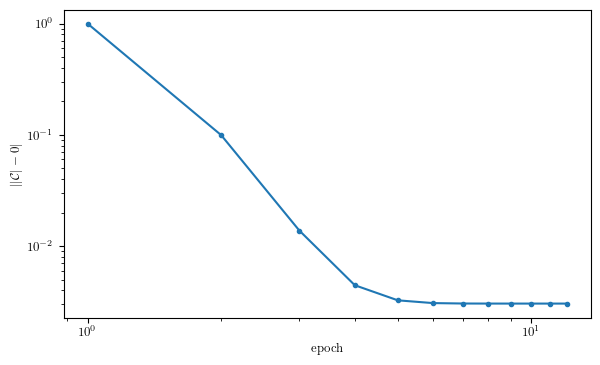

In [43]:
plot_chern(nu_list,log=True,C=0)

In [125]:
measure_feedback_layer()
for i in range(1):
    randomize()
    measure_feedback_layer()


100%|██████████| 144/144 [00:07<00:00, 19.34it/s]


In [126]:
nu_list_step = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]


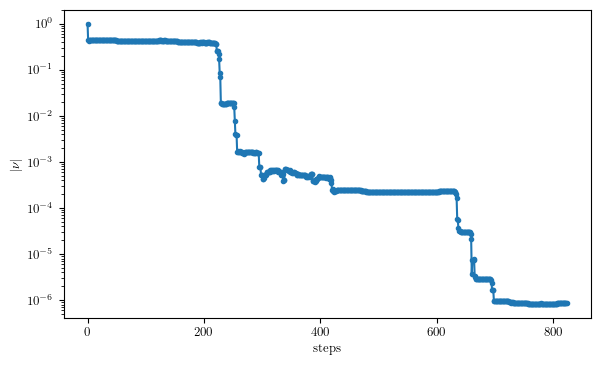

In [127]:
fig,ax=plt.subplots()
ax.plot(np.arange(len(nu_list_step)),np.abs(np.array(nu_list_step)/2),'.-')
# ax.set_xlabel('steps')
ax.set_xlabel('steps')
ax.set_ylabel(r'${\abs{\nu}}$')
# ax.set_xscale('log')
ax.set_yscale('log')

## From C=-1 to C=1

In [44]:
gtn2=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=-1)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=-1)

Text(0, 0.5, '$j$')

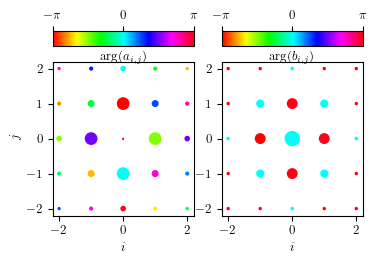

In [45]:
fig,ax=plt.subplots(1,2,figsize=(4,2))

i_list,j_list,a_list=convert_to_list(gtn2.a_i)
im=ax[0].scatter(i_list,j_list,s=400*np.abs(a_list),c=np.angle(a_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

i_list,j_list,b_list=convert_to_list(gtn2.b_i)
im=ax[1].scatter(i_list,j_list,s=400*np.abs(b_list),c=np.angle(b_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

place_color_bar_top(im,ax[0],r'$\arg(a_{i,j})$')
place_color_bar_top(im,ax[1],r'$\arg(b_{i,j})$')

[ax.set_xlabel('$i$') for ax in ax]
ax[0].set_ylabel('$j$')




In [46]:
with open('C_m_15.pickle','rb') as f:
    C_m=pickle.load(f)
gtn2.C_m[:2*gtn2.L,:2*gtn2.L]=C_m
gtn2.C_m_history[0]=gtn2.C_m.copy()

In [47]:
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [48]:
chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)

-0.9995557038379123

In [49]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [50]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
measure_feedback_layer()
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
for i in range(10):
    randomize()
    measure_feedback_layer()
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))


100%|██████████| 225/225 [00:24<00:00,  9.02it/s]


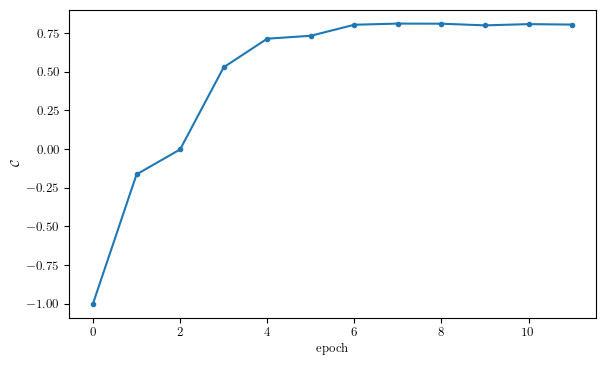

In [52]:
plot_chern(nu_list)

Text(0, 0.5, '${\\nu}$')

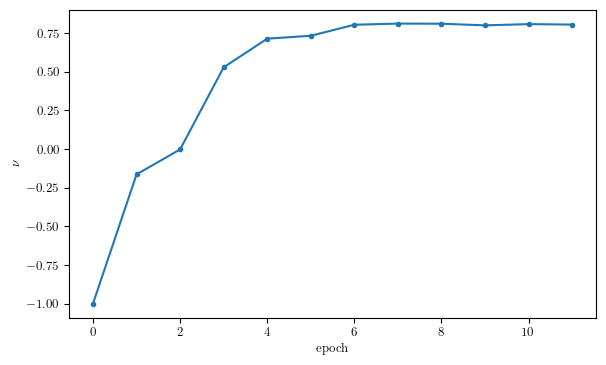

In [51]:
fig,ax=plt.subplots()
ax.plot(np.arange(len(nu_list)),(np.array(nu_list)),'.-')

# ax.set_xlabel('steps')
ax.set_xlabel('epoch')
ax.set_ylabel(r'${\nu}$')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-2,None)

## C=0 -> C=2

In [20]:
gtn2=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=4,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=1,C=2)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=1,C=2)

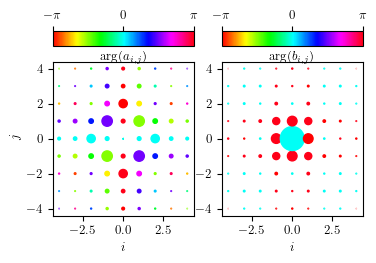

In [22]:
fig,ax=plt.subplots(1,2,figsize=(4,2))

i_list,j_list,a_list=convert_to_list(gtn2.a_i)
im=ax[0].scatter(i_list,j_list,s=400*np.abs(a_list),c=np.angle(a_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

i_list,j_list,b_list=convert_to_list(gtn2.b_i)
im=ax[1].scatter(i_list,j_list,s=400*np.abs(b_list),c=np.angle(b_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

place_color_bar_top(im,ax[0],r'$\arg(a_{i,j})$')
place_color_bar_top(im,ax[1],r'$\arg(b_{i,j})$')

[ax.set_xlabel('$i$') for ax in ax]
ax[0].set_ylabel('$j$')

fig.savefig('mu1_nshell4_C2.pdf',bbox_inches='tight')



In [307]:
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [308]:
chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)

-0.06867867743391619

In [309]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [310]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
measure_feedback_layer()
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
for i in range(10):
    randomize()
    measure_feedback_layer()
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))


  0%|          | 0/225 [00:00<?, ?it/s]

100%|██████████| 225/225 [00:24<00:00,  9.00it/s]


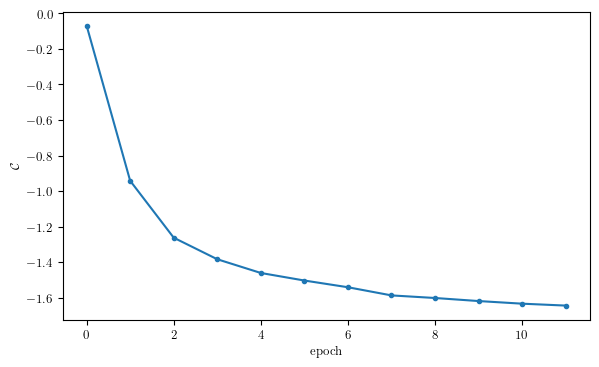

In [327]:
plot_chern(nu_list)

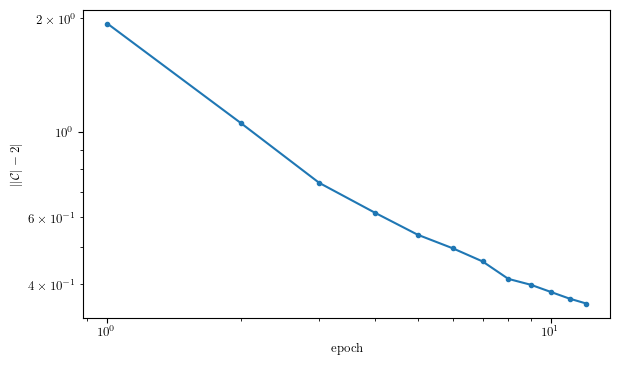

In [326]:
plot_chern(nu_list,log=True,C=2)

# Load figure

In [36]:
nshell_list = [1,2,3,4]
L_list = [15,18,21]
gtn2 ={}
nu_list = {}
for L in L_list:
    for nshell in nshell_list:
        with open(f'class_A_2D_L{L}_nshell{nshell}_mu1.00.pickle','rb') as f:
            [gtn2_,nu_list_]=pickle.load(f)
            gtn2[(L,nshell)]=gtn2_
            nu_list[(L,nshell)]=nu_list_


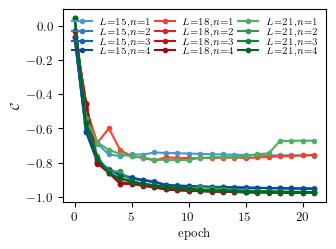

In [43]:
fig,ax=plt.subplots(figsize=(3.4,2.5))
color_list={
    15:iter(plt.cm.Blues(np.linspace(0.6,0.9,len(nshell_list)))),
    18:iter(plt.cm.Reds(np.linspace(0.6,0.9,len(nshell_list)))),
    21:iter(plt.cm.Greens(np.linspace(0.6,0.9,len(nshell_list)))),}
for L in L_list:
    for nshell in nshell_list:
        plot_chern(nu_list[(L,nshell)],ax=ax,label=f'$L$={L},$n$={nshell}',color=next(color_list[L]))
ax.legend(ncols=3,frameon=False,labelspacing=0.1,columnspacing=0.5,fontsize=7,loc='upper center')
fig.savefig('chern_mu1.pdf',bbox_inches='tight')

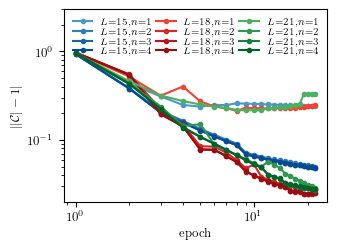

In [44]:
fig,ax=plt.subplots(figsize=(3.4,2.5))

color_list={
    15:iter(plt.cm.Blues(np.linspace(0.6,0.9,len(nshell_list)))),
    18:iter(plt.cm.Reds(np.linspace(0.6,0.9,len(nshell_list)))),
    21:iter(plt.cm.Greens(np.linspace(0.6,0.9,len(nshell_list)))),}
for L in L_list:
    for nshell in nshell_list:
        plot_chern(nu_list[(L,nshell)],ax=ax,log=True,C=1,label=f'$L$={L},$n$={nshell}',color=next(color_list[L]))
ax.legend()
ax.legend(ncols=3,frameon=False,labelspacing=0.1,columnspacing=0.5,fontsize=7,loc='upper center')
ax.set_ylim(None,3)
fig.savefig('chern_mu1_log.pdf',bbox_inches='tight')

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])

In [53]:
nshell = 2
L = 18
mu_list = np.round(np.linspace(0.2,1.8,9),2)
# mu_list = [.4,.8,1,1.2,1.6]
gtn2 ={}
nu_list = {}
for mu in mu_list:
    with open(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}.pickle','rb') as f:
        [gtn2_,nu_list_]=pickle.load(f)
        gtn2[mu]=gtn2_
        nu_list[mu]=nu_list_


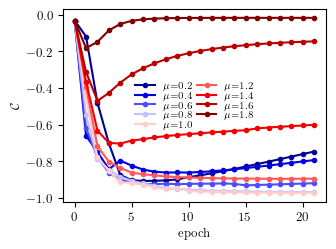

In [54]:
fig,ax=plt.subplots(figsize=(3.4,2.5))
color_list=iter(plt.cm.seismic(np.linspace(0.1,1,len(mu_list))))

for mu in mu_list:
    plot_chern(nu_list[mu],ax=ax,label=f'$\mu$={mu}',color=next(color_list))
# ax.legend(ncols=2,frameon=False)
ax.legend(ncols=2,frameon=False,labelspacing=0.1,columnspacing=0.5,fontsize=7,)
# fig.savefig('chern_L18_nshell2.pdf',bbox_inches='tight')

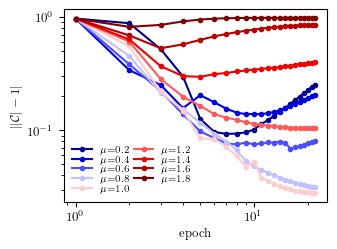

In [55]:
fig,ax=plt.subplots(figsize=(3.4,2.5))

color_list=iter(plt.cm.seismic(np.linspace(0.1,1,len(mu_list))))
for mu in mu_list:
    plot_chern(nu_list[mu],ax=ax,label=f'$\mu$={mu}',color=next(color_list),log=True,C=1)
ax.legend()
ax.legend(ncols=2,frameon=False,labelspacing=0.1,columnspacing=0.5,fontsize=7,)
# fig.savefig('chern_L18_nshell2_log.pdf',bbox_inches='tight')

## Localization length

In [183]:
gtn2=GTN2(Lx=18,Ly=18,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=4,op=True)


In [217]:
a_i,b_i =amplitude_fft(nkx=1000,nky=1000,mu=1)

In [211]:
a_i_0,b_i_0 =amplitude_fft(nkx=1000,nky=1000,mu=0.5)

In [191]:
a_i_1,b_i_1 =amplitude_fft(nkx=1000,nky=1000,mu=2.1)

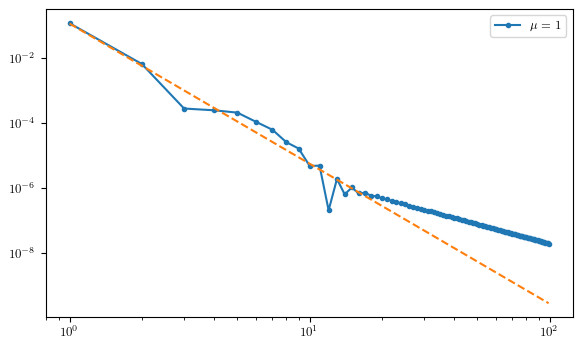

In [230]:
i_list = np.arange(1,100)

plt.plot(i_list,np.abs(b_i[0][1:100]),'.-',label=r'$\mu=1$')
# plt.plot(i_list,np.abs(b_i_0[0][1:100]),'.-',label=r'$\mu=0.4$')
# plt.plot(i_list,np.abs(b_i_1[0][1:100]),'.-',label=r'$\mu=2.1$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.plot(i_list,np.exp(np.polyval(loc_len,np.log(i_list))),'--',label='fit')

In [223]:
def fit_slope(x,y):
    return np.polyfit(np.log(x),np.log(y),1)

In [240]:
def localization_len(mu,imax=20):
    i_list = np.arange(1,imax)
    a_i,b_i =amplitude_fft(nkx=1000,nky=1000,mu=mu)
    return a_i,b_i, fit_slope(i_list,np.abs(a_i[0][1:imax])), fit_slope(i_list,np.abs(b_i[0][1:imax]))

In [264]:
mu_list = np.linspace(0.2,1.6,15)
loc_a_len_list=[]
loc_b_len_list=[]
a_i_list=[]
b_i_list=[]
for mu in mu_list:
    a_i,b_i,loc_a_len, loc_b_len = localization_len(mu)
    a_i_list.append(a_i)
    b_i_list.append(b_i)
    loc_a_len_list.append(loc_a_len)
    loc_b_len_list.append(loc_b_len)

# loc_len = [localization_len(mu) for mu in mu_list]
# loc_len = np.vstack(loc_len)

In [266]:
np.linspace(0.2,1.6,15)[::4]

array([0.2, 0.6, 1. , 1.4])

Text(0, 0.5, '$\\abs{a}$')

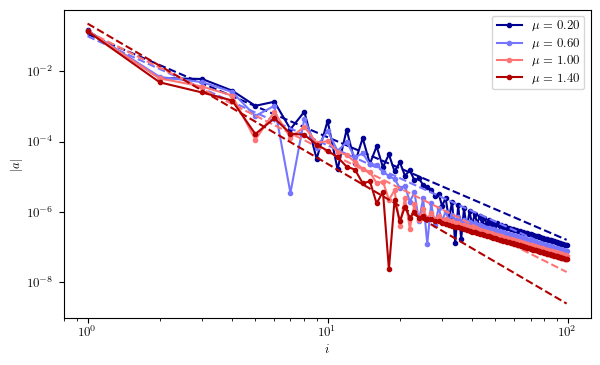

In [279]:
fig,ax=plt.subplots()
color_list = iter(plt.cm.seismic(np.linspace(0.1,0.9,4)))
for idx,mu in enumerate(mu_list[::4]):
    color=next(color_list)
    ax.plot(i_list,np.abs(b_i_list[idx][0][1:100]),'.-',label=rf'$\mu={mu:.2f}$',color=color)
    ax.plot(i_list,np.exp(np.polyval(loc_b_len_list[idx],np.log(i_list))),'--',color=color)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ax.set_xlabel('$i$')
ax.set_ylabel(r'$\abs{a}$')

Text(0, 0.5, '$\\abs{b}$')

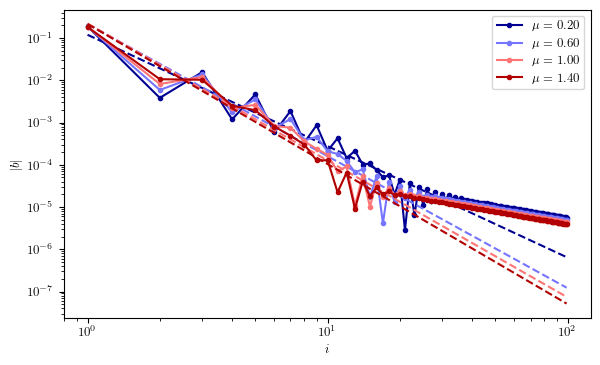

In [280]:
fig,ax=plt.subplots()
color_list = iter(plt.cm.seismic(np.linspace(0.1,0.9,4)))
for idx,mu in enumerate(mu_list[::4]):
    color=next(color_list)
    ax.plot(i_list,np.abs(a_i_list[idx][0][1:100]),'.-',label=rf'$\mu={mu:.2f}$',color=color)
    ax.plot(i_list,np.exp(np.polyval(loc_a_len_list[idx],np.log(i_list))),'--',color=color)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

ax.set_xlabel('$i$')
ax.set_ylabel(r'$\abs{b}$')

Text(0, 0.5, '$-\\frac{1}{\\xi}$')

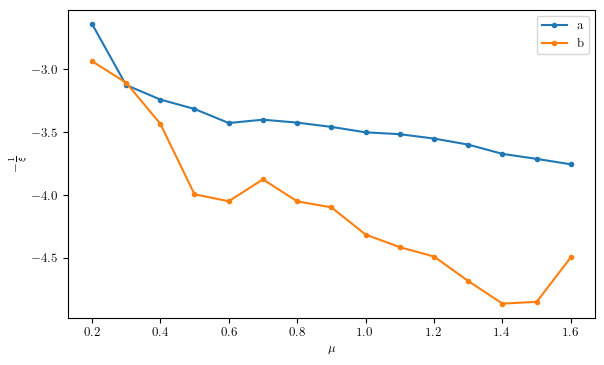

In [272]:
fig,ax=plt.subplots()
ax.plot(mu_list,np.vstack(loc_a_len_list)[:,0],'.-',label='a')
ax.plot(mu_list,np.vstack(loc_b_len_list)[:,0],'.-',label='b')
ax.legend()
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$-\frac{1}{\xi}$')

In [207]:
fit_slope(i_list,np.abs(b_i[0][1:100]))

-2.886198753729388

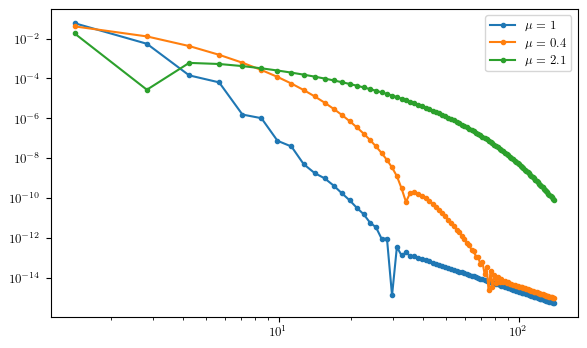

In [201]:
i_list = np.arange(1,100)

plt.plot(i_list*np.sqrt(2),np.abs(np.diag(b_i)[1:100]),'.-',label=r'$\mu=1$')
plt.plot(i_list*np.sqrt(2),np.abs(np.diag(b_i_0)[1:100]),'.-',label=r'$\mu=0.4$')
plt.plot(i_list*np.sqrt(2),np.abs(np.diag(b_i_1)[1:100]),'.-',label=r'$\mu=2.1$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

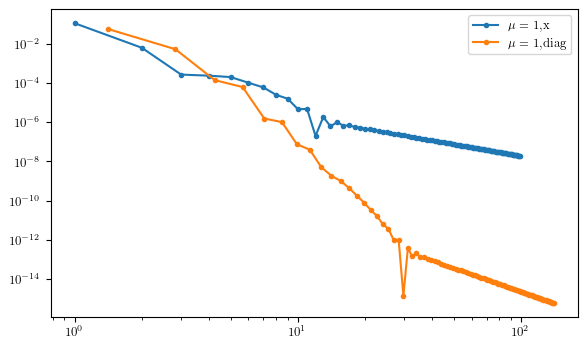

In [205]:
i_list = np.arange(1,100)

plt.plot(i_list,np.abs(b_i[0][1:100]),'.-',label=r'$\mu=1$,x')
plt.plot(i_list*np.sqrt(2),np.abs(np.diag(b_i)[1:100]),'.-',label=r'$\mu=1$,diag')

plt.xscale('log')
plt.yscale('log')
plt.legend()

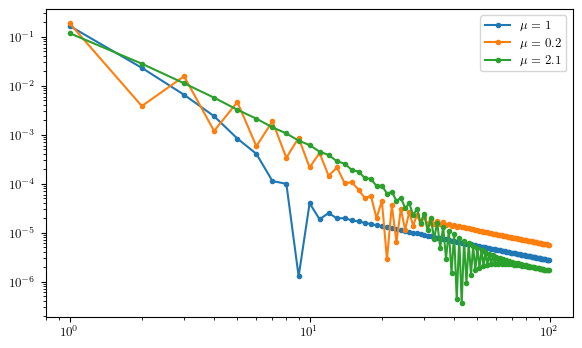

In [196]:
i_list = np.arange(1,100)
plt.plot(i_list,np.abs(a_i[0][1:100]),'.-',label=r'$\mu=1$')
plt.plot(i_list,np.abs(a_i_0[0][1:100]),'.-',label=r'$\mu=0.2$')
plt.plot(i_list,np.abs(a_i_1[0][1:100]),'.-',label=r'$\mu=2.1$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

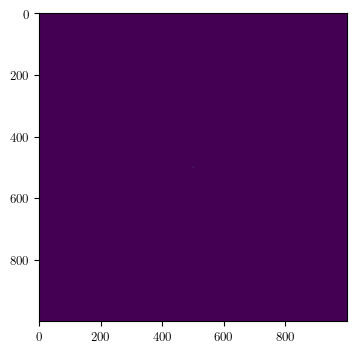

In [194]:
plt.imshow(np.abs(np.fft.fftshift(b_i)))

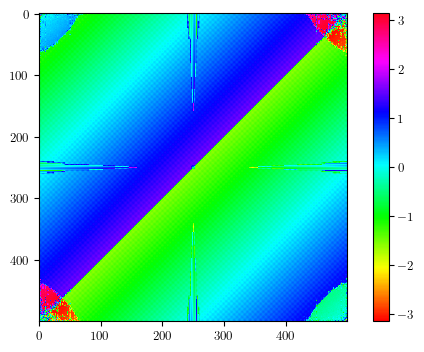

In [118]:
plt.imshow(np.angle(np.fft.fftshift(b_i)),vmin=-np.pi,vmax=np.pi,cmap='hsv')
plt.colorbar()

# Open boundary condition

In [10]:
gtn2=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=2.1)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=2.1)

In [11]:
with open('C_m_L15_OBC.pickle','rb') as f:
    C_m=pickle.load(f)
gtn2.C_m[:2*gtn2.L,:2*gtn2.L]=C_m
gtn2.C_m_history[0]=gtn2.C_m.copy()

In [12]:
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [13]:
chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)

-0.9999710430891109

In [14]:
chern_number_quick(gtn2.C_m,A_idx_0+2*gtn2.L,B_idx_0+2*gtn2.L,C_idx_0+2*gtn2.L)

0.02633762791696444

In [15]:
get_C_f(gtn2.C_m).shape

(900, 900)

In [16]:
n0=np.diag(get_C_f(gtn2.C_m))[:gtn2.L].reshape((gtn2.Lx,gtn2.Ly,2))

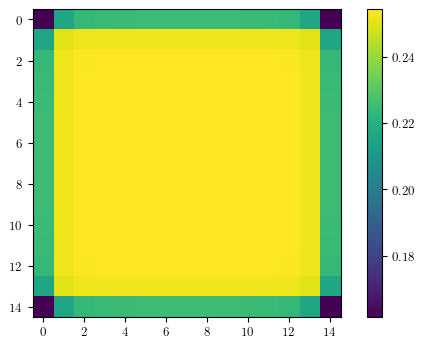

In [17]:
plt.imshow(np.abs(n0[:,:,0]))
plt.colorbar()

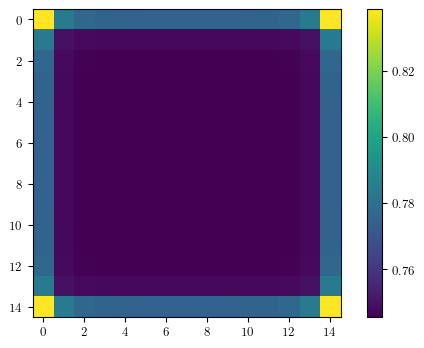

In [18]:
plt.imshow(np.abs(n0[:,:,1]))
plt.colorbar()

## <c^+(0)c(r)>

In [25]:
gtn2=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=2.1)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=2.1)

In [27]:
with open('C_m_L15.pickle','rb') as f:
    C_m=pickle.load(f)
gtn2.C_m[:2*gtn2.L,:2*gtn2.L]=C_m
gtn2.C_m_history[0]=gtn2.C_m.copy()

In [36]:
C_f_a = get_C_f(gtn2.C_m)[:gtn2.L,:gtn2.L][225]

In [37]:
corr_a = C_f_a.reshape((gtn2.Lx,gtn2.Ly,2))

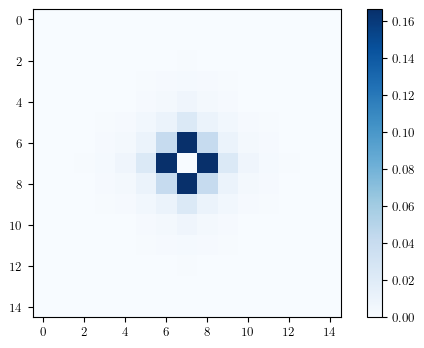

In [42]:
plt.imshow(np.abs(corr_a[:,:,0]),cmap='Blues')
plt.colorbar()

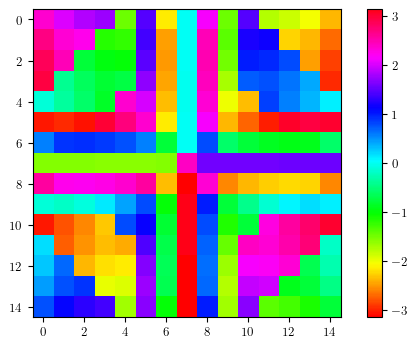

In [43]:
plt.imshow(np.angle(corr_a[:,:,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

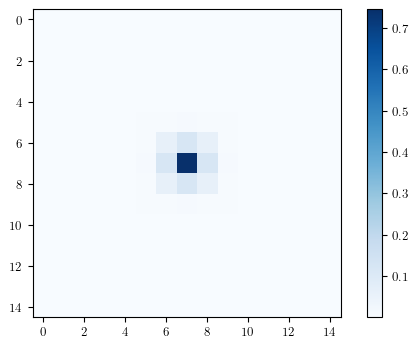

In [45]:
plt.imshow(np.abs(corr_a[:,:,1]),cmap='Blues')
plt.colorbar()

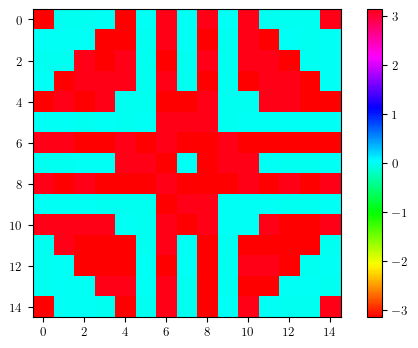

In [46]:
plt.imshow(np.angle(corr_a[:,:,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

In [56]:
C_f_b = get_C_f(gtn2.C_m)[:gtn2.L,:gtn2.L][226]

In [57]:
corr_b = C_f_b.reshape((gtn2.Lx,gtn2.Ly,2))

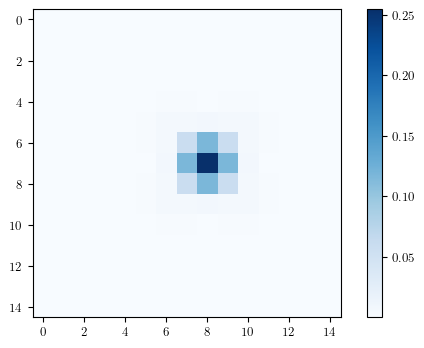

In [58]:
plt.imshow(np.abs(corr_b[:,:,0]),cmap='Blues')
plt.colorbar()

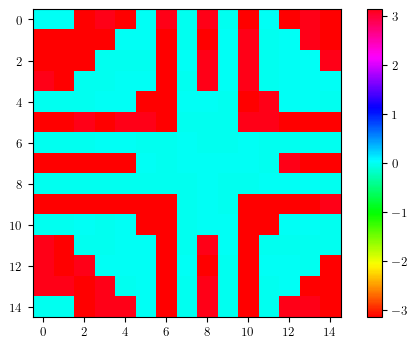

In [59]:
plt.imshow(np.angle(corr_b[:,:,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

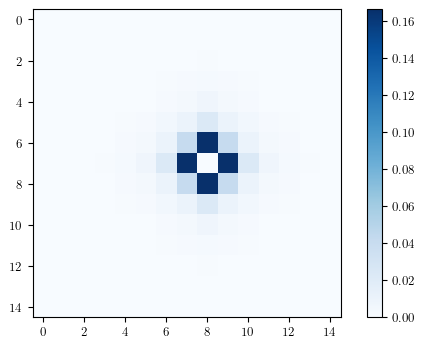

In [60]:
plt.imshow(np.abs(corr_b[:,:,1]),cmap='Blues')
plt.colorbar()

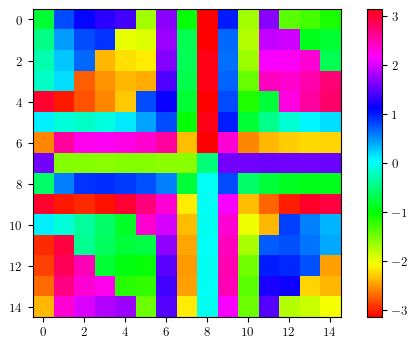

In [61]:
plt.imshow(np.angle(corr_b[:,:,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

## C=2 

In [10]:
gtn2=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=1,C=2)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=1,C=2)

In [11]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [13]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
measure_feedback_layer(gtn2, margin=2)
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
for i in range(10):
    randomize(gtn2)
    measure_feedback_layer(gtn2, margin=2)
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))


100%|██████████| 121/121 [00:32<00:00,  3.67it/s]


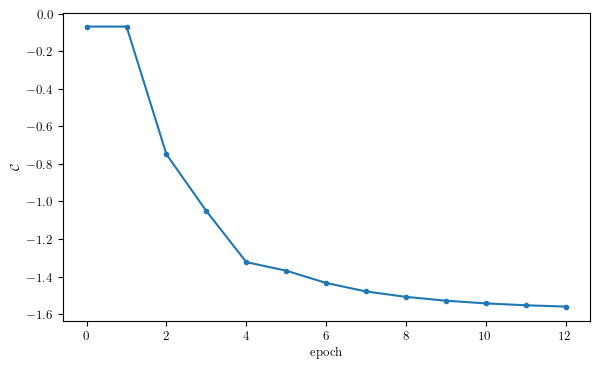

In [14]:
plot_chern(nu_list)

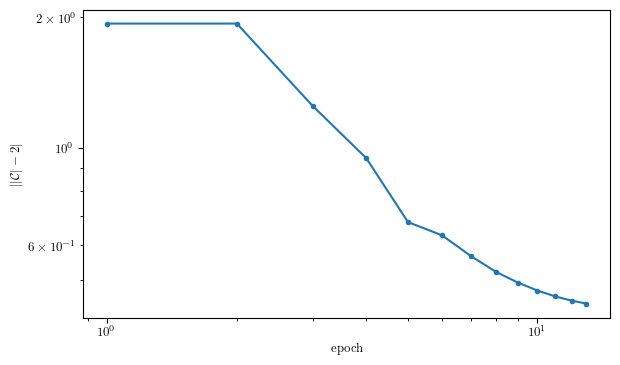

In [30]:
plot_chern(nu_list,log=True,C=2)

In [15]:
n0=np.diag(get_C_f(gtn2.C_m))[:gtn2.L].reshape((gtn2.Lx,gtn2.Ly,2))

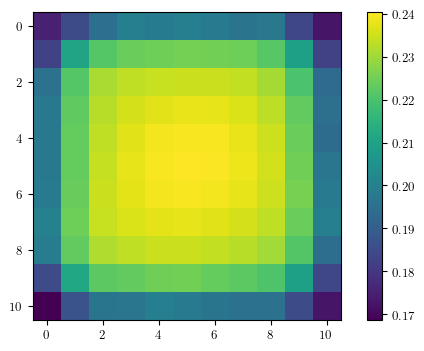

In [16]:
plt.imshow(np.abs(n0[2:13,2:13,0]))
plt.colorbar()

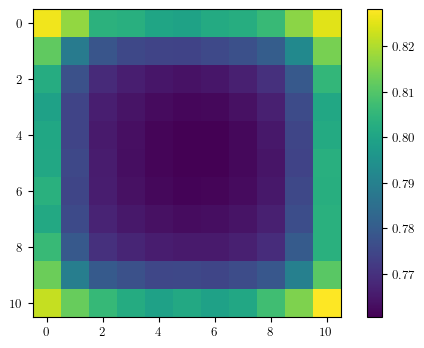

In [17]:
plt.imshow(np.abs(n0[2:13,2:13,1]))
plt.colorbar()

In [18]:
C_f_a = get_C_f(gtn2.C_m)[:gtn2.L,:gtn2.L][gtn2.L//2]

In [19]:
corr_a = C_f_a.reshape((gtn2.Lx,gtn2.Ly,2))

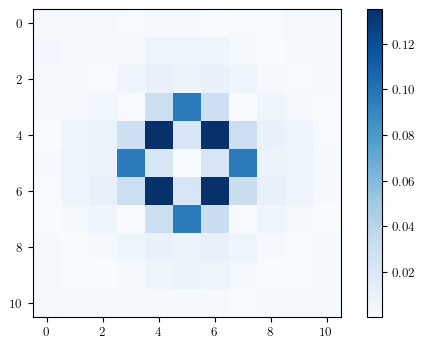

In [20]:
plt.imshow(np.abs(corr_a[2:13,2:13,0]),cmap='Blues')
plt.colorbar()

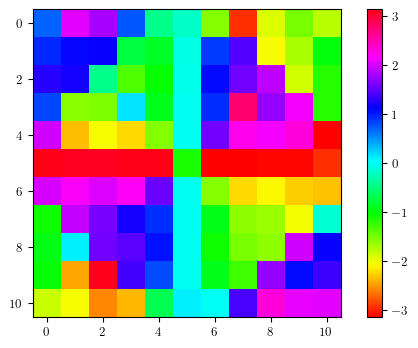

In [21]:
plt.imshow(np.angle(corr_a[2:13,2:13,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

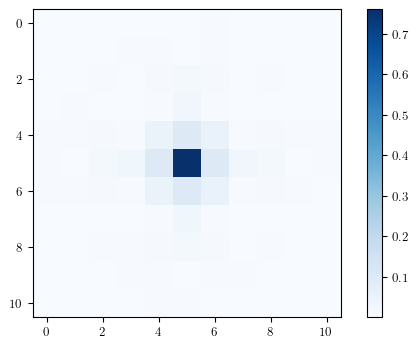

In [22]:
plt.imshow(np.abs(corr_a[2:13,2:13,1]),cmap='Blues')
plt.colorbar()

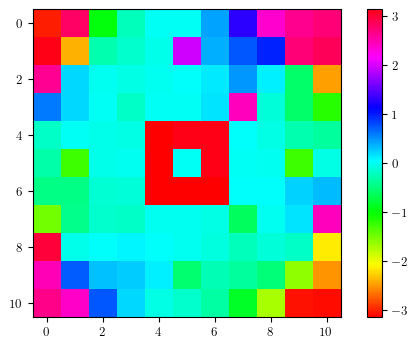

In [23]:
plt.imshow(np.angle(corr_a[2:13,2:13,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

In [24]:
C_f_b = get_C_f(gtn2.C_m)[:gtn2.L,:gtn2.L][gtn2.L//2+1]

In [25]:
corr_b = C_f_b.reshape((gtn2.Lx,gtn2.Ly,2))

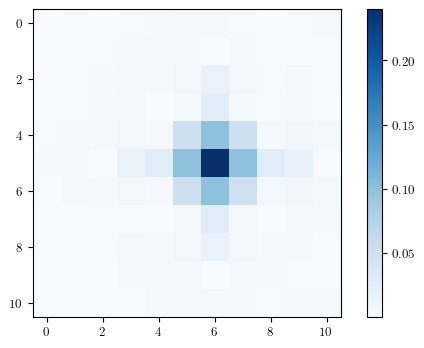

In [26]:
plt.imshow(np.abs(corr_b[2:13,2:13,0]),cmap='Blues')
plt.colorbar()

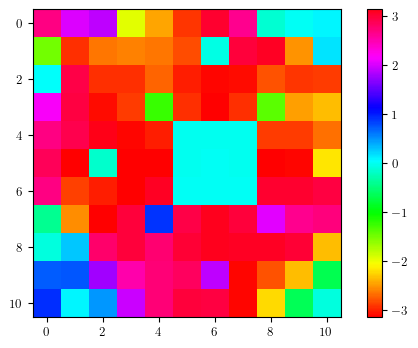

In [27]:
plt.imshow(np.angle(corr_b[2:13,2:13,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

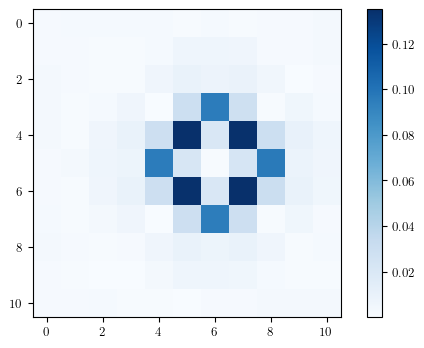

In [28]:
plt.imshow(np.abs(corr_b[2:13,2:13,1]),cmap='Blues')
plt.colorbar()

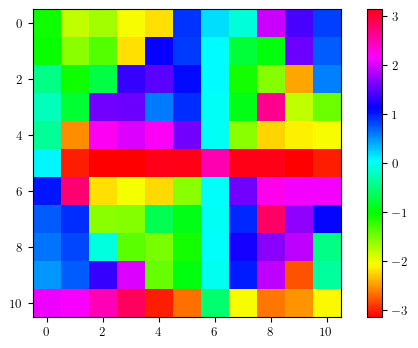

In [29]:
plt.imshow(np.angle(corr_b[2:13,2:13,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

## C=1 

In [91]:
gtn2=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,op=True)
gtn2.a_i,gtn2.b_i = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=1)
gtn2.A_i,gtn2.B_i = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=1)

In [92]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [93]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
measure_feedback_layer(margin=2)
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))
for i in range(10):
    randomize()
    measure_feedback_layer(margin=2)
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))


100%|██████████| 121/121 [00:27<00:00,  4.42it/s]


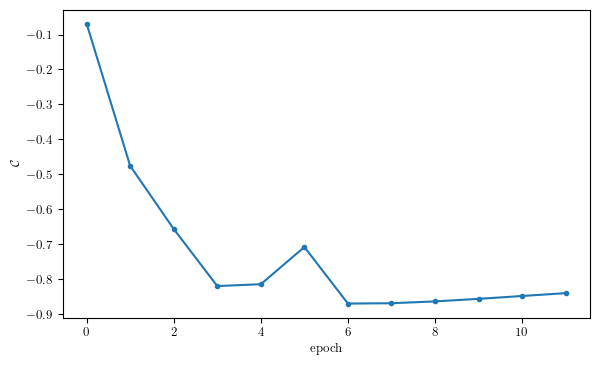

In [94]:
plot_chern(nu_list)

In [95]:
n0=np.diag(get_C_f(gtn2.C_m))[:gtn2.L].reshape((gtn2.Lx,gtn2.Ly,2))

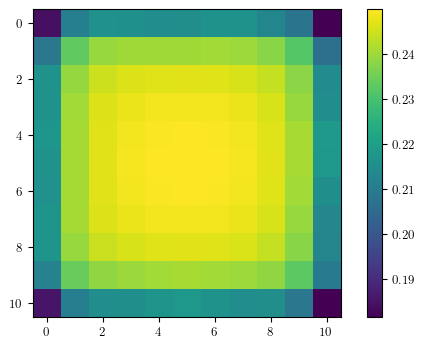

In [112]:
plt.imshow(np.abs(n0[2:13,2:13,0]))
plt.colorbar()

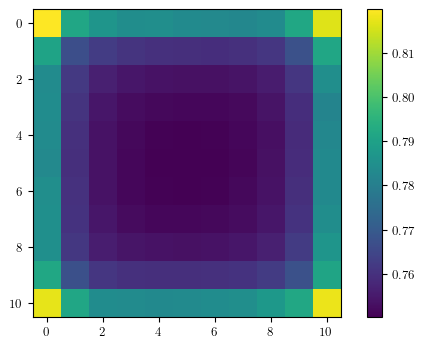

In [113]:
plt.imshow(np.abs(n0[2:13,2:13,1]))
plt.colorbar()

In [114]:
C_f_a = get_C_f(gtn2.C_m)[:gtn2.L,:gtn2.L][gtn2.L//2]

In [115]:
corr_a = C_f_a.reshape((gtn2.Lx,gtn2.Ly,2))

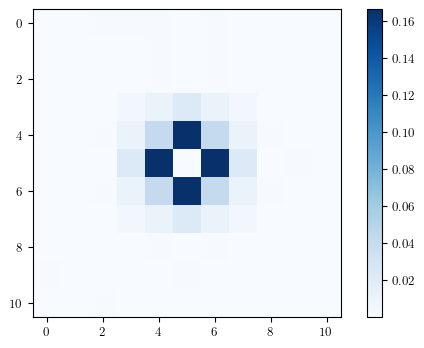

In [116]:
plt.imshow(np.abs(corr_a[2:13,2:13,0]),cmap='Blues')
plt.colorbar()

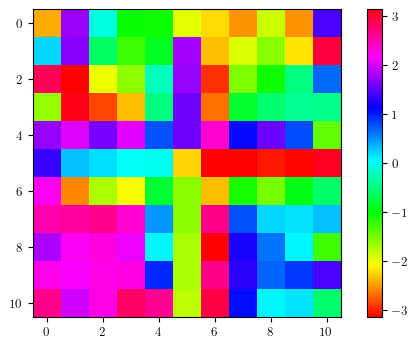

In [117]:
plt.imshow(np.angle(corr_a[2:13,2:13,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

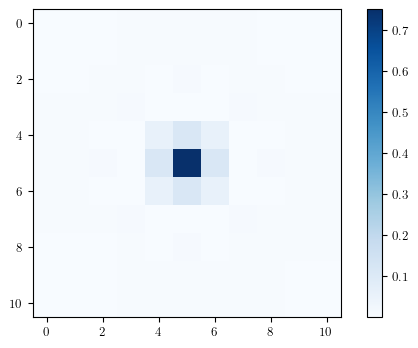

In [118]:
plt.imshow(np.abs(corr_a[2:13,2:13,1]),cmap='Blues')
plt.colorbar()

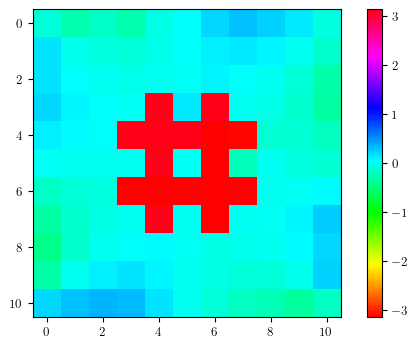

In [119]:
plt.imshow(np.angle(corr_a[2:13,2:13,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

In [120]:
C_f_b = get_C_f(gtn2.C_m)[:gtn2.L,:gtn2.L][gtn2.L//2+1]

In [121]:
corr_b = C_f_b.reshape((gtn2.Lx,gtn2.Ly,2))

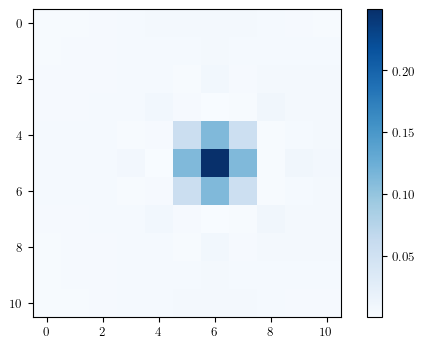

In [122]:
plt.imshow(np.abs(corr_b[2:13,2:13,0]),cmap='Blues')
plt.colorbar()

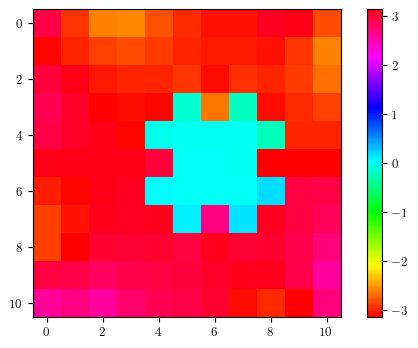

In [123]:
plt.imshow(np.angle(corr_b[2:13,2:13,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

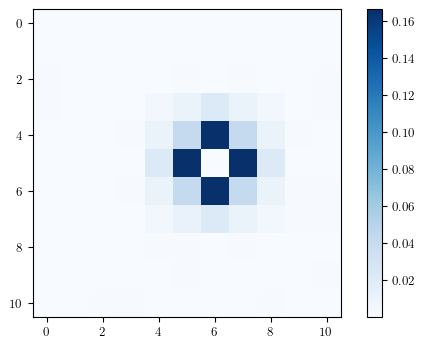

In [124]:
plt.imshow(np.abs(corr_b[2:13,2:13,1]),cmap='Blues')
plt.colorbar()

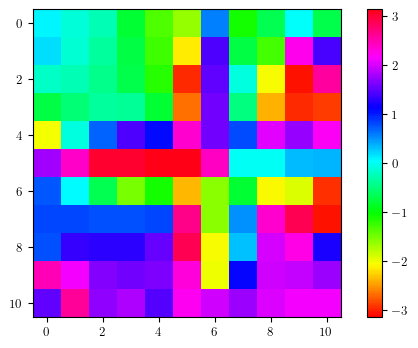

In [125]:
plt.imshow(np.angle(corr_b[2:13,2:13,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

## C=0

In [175]:
gtn2_0=GTN2(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,op=True)
gtn2_0.a_i,gtn2_0.b_i = amplitude(gtn2_0.nshell,tau=[0,1],geometry='square',lower=True,mu=2.1)
gtn2_0.A_i,gtn2_0.B_i = amplitude(gtn2_0.nshell,tau=[1,0],geometry='square',lower=False,mu=2.1)

In [176]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2_0.generate_tripartite_circle()

In [177]:
nu_list.append( chern_number_quick(gtn2_0.C_m,A_idx_0,B_idx_0,C_idx_0))
measure_feedback_layer(gtn2_0,margin=2)
nu_list.append( chern_number_quick(gtn2_0.C_m,A_idx_0,B_idx_0,C_idx_0))
for i in range(5):
    randomize(gtn2_0)
    measure_feedback_layer(gtn2_0,margin=2)
    nu_list.append( chern_number_quick(gtn2_0.C_m,A_idx_0,B_idx_0,C_idx_0))


100%|██████████| 121/121 [00:25<00:00,  4.71it/s]


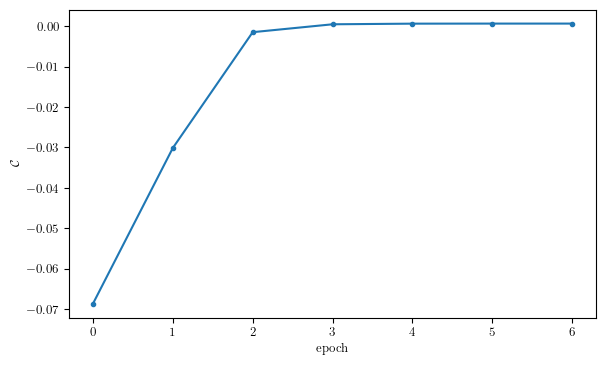

In [178]:
plot_chern(nu_list)

In [179]:
n0=np.diag(get_C_f(gtn2_0.C_m))[:gtn2_0.L].reshape((gtn2_0.Lx,gtn2_0.Ly,2))

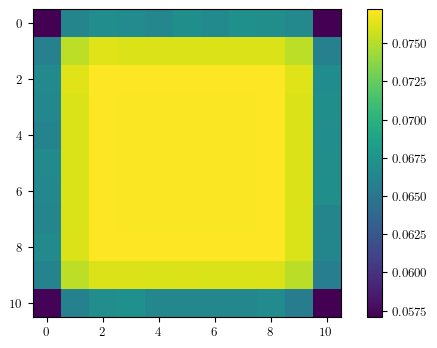

In [180]:
plt.imshow(np.abs(n0[2:13,2:13,0]))
plt.colorbar()

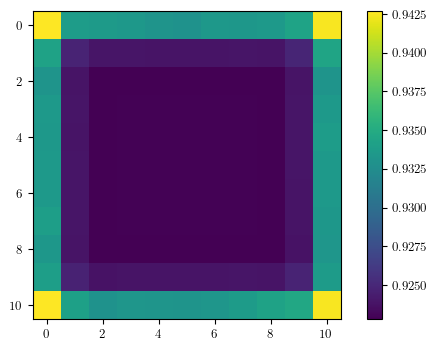

In [181]:
plt.imshow(np.abs(n0[2:13,2:13,1]))
plt.colorbar()

In [182]:
C_f_a = get_C_f(gtn2_0.C_m)[:gtn2_0.L,:gtn2_0.L][gtn2_0.L//2]

In [183]:
corr_a = C_f_a.reshape((gtn2_0.Lx,gtn2_0.Ly,2))

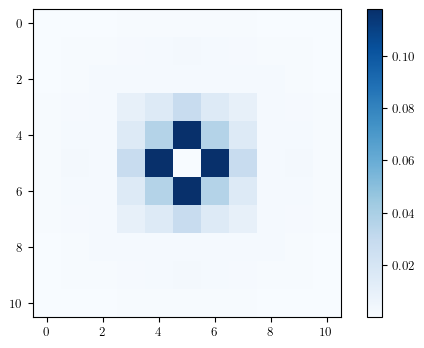

In [184]:
plt.imshow(np.abs(corr_a[2:13,2:13,0]),cmap='Blues')
plt.colorbar()

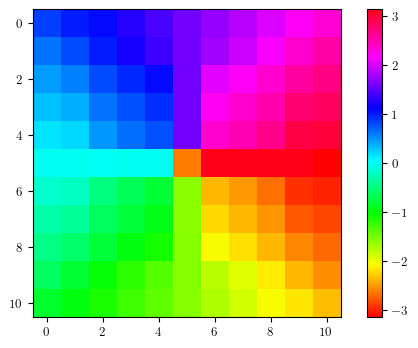

In [185]:
plt.imshow(np.angle(corr_a[2:13,2:13,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

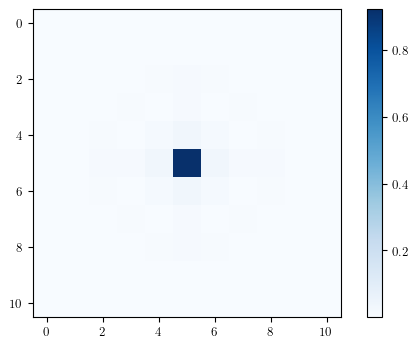

In [186]:
plt.imshow(np.abs(corr_a[2:13,2:13,1]),cmap='Blues')
plt.colorbar()

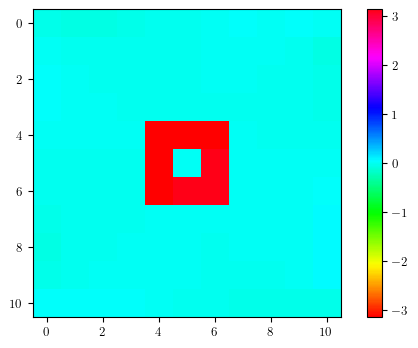

In [187]:
plt.imshow(np.angle(corr_a[2:13,2:13,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

In [188]:
C_f_b = get_C_f(gtn2_0.C_m)[:gtn2_0.L,:gtn2_0.L][gtn2_0.L//2+1]

In [189]:
corr_b = C_f_b.reshape((gtn2_0.Lx,gtn2_0.Ly,2))

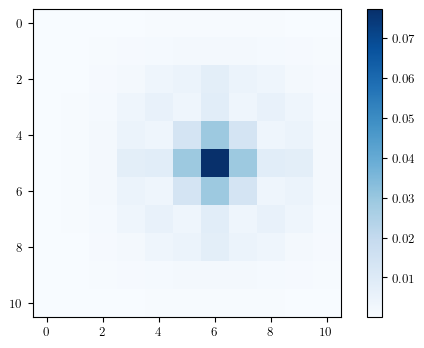

In [190]:
plt.imshow(np.abs(corr_b[2:13,2:13,0]),cmap='Blues')
plt.colorbar()

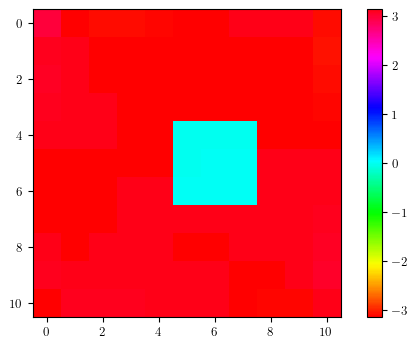

In [191]:
plt.imshow(np.angle(corr_b[2:13,2:13,0]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

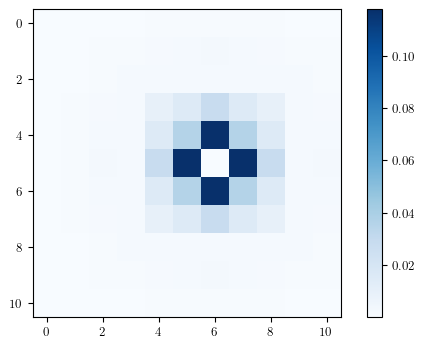

In [194]:
plt.imshow(np.abs(corr_b[2:13,2:13,1]),cmap='Blues')
plt.colorbar()

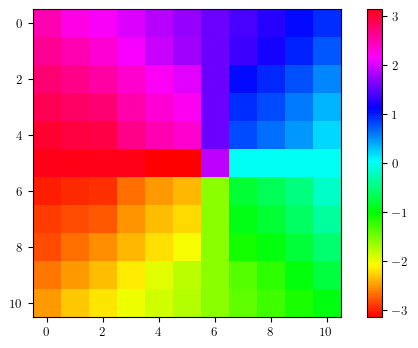

In [195]:
plt.imshow(np.angle(corr_b[2:13,2:13,1]),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.colorbar()

# Draft

In [54]:
u=(1,2j,3,4j,5.1)
np.allclose(Gamma_n1(u,1),Gamma_n1_new(u,1))

True

In [45]:
Gamma_n1_new((1,1),1)

array([[ 0. ,  0.5,  0. ,  0.5,  0.5,  0. , -0.5,  0. ],
       [-0.5,  0. , -0.5,  0. ,  0. ,  0.5,  0. , -0.5],
       [ 0. ,  0.5,  0. ,  0.5, -0.5,  0. ,  0.5,  0. ],
       [-0.5,  0. , -0.5,  0. ,  0. , -0.5,  0. ,  0.5],
       [-0.5, -0. ,  0.5, -0. , -0. , -0.5, -0. , -0.5],
       [-0. , -0.5, -0. ,  0.5,  0.5, -0. ,  0.5, -0. ],
       [ 0.5, -0. , -0.5, -0. , -0. , -0.5, -0. , -0.5],
       [-0. ,  0.5, -0. , -0.5,  0.5, -0. ,  0.5, -0. ]])

In [286]:
a_i_0,b_i_0=amplitude(1,tau=[0,1],)

In [287]:
a_i_0,b_i_0

({(-1, -1): (0.02902348183227568+0.029023481832275676j),
  (-1, 0): (2.168881922062419e-19+0.1664909147383517j),
  (-1, 1): (-0.02902348183227568+0.029023481832275676j),
  (0, -1): (0.16649091473835168+0j),
  (0, 0): (8.675527688249409e-19+0j),
  (0, 1): (-0.16649091473835168-2.8122277740499295e-18j),
  (1, -1): (0.029023481832275693-0.02902348183227568j),
  (1, 0): (4.736129911442252e-19-0.16649091473835168j),
  (1, 1): (-0.029023481832275693-0.02902348183227568j)},
 {(-1, -1): (-0.05837376856280478+0j),
  (-1, 0): (-0.11674753712560951-2.1246190256937667e-19j),
  (-1, 1): (-0.058373768562804754-5.624455548099859e-18j),
  (0, -1): (-0.11674753712560951+0j),
  (0, 0): (0.7455845790816228+0j),
  (0, 1): (-0.11674753712560951+0j),
  (1, -1): (-0.058373768562804754+5.624455548099859e-18j),
  (1, 0): (-0.11674753712560951+2.1246190256937667e-19j),
  (1, 1): (-0.05837376856280478+0j)})

In [288]:
a_i,b_i=amplitude(1,tau=[1,0],lower=False)

In [289]:
a_i,b_i

({(-1, -1): (-0.05837376856280478+0j),
  (-1, 0): (-0.11674753712560951-2.1246190256937667e-19j),
  (-1, 1): (-0.058373768562804754-5.624455548099859e-18j),
  (0, -1): (-0.11674753712560951+0j),
  (0, 0): (0.7455845790816228+0j),
  (0, 1): (-0.11674753712560951+0j),
  (1, -1): (-0.058373768562804754+5.624455548099859e-18j),
  (1, 0): (-0.11674753712560951+2.1246190256937667e-19j),
  (1, 1): (-0.05837376856280478+0j)},
 {(-1, -1): (0.029023481832275693-0.02902348183227568j),
  (-1, 0): (-4.736129911442252e-19-0.16649091473835168j),
  (-1, 1): (-0.029023481832275693-0.02902348183227568j),
  (0, -1): (0.16649091473835168-2.8122277740499295e-18j),
  (0, 0): (-8.675527688249409e-19+0j),
  (0, 1): (-0.16649091473835168+0j),
  (1, -1): (0.02902348183227568+0.029023481832275676j),
  (1, 0): (-2.168881922062419e-19+0.1664909147383517j),
  (1, 1): (-0.02902348183227568+0.029023481832275676j)})

In [319]:
v=np.hstack([a_i[0,0],b_i[0,0]])
np.abs(v)**2/(v.conj()@v)

array([0.25177955+0.j, 0.74822045+0.j])

In [320]:
a_i,b_i=amplitude(5,tau=[1.7,1])

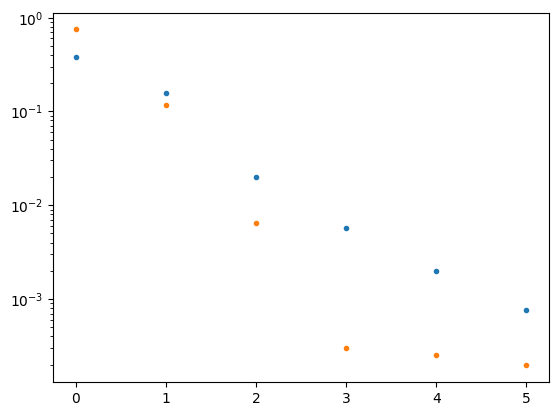

In [321]:
plt.plot([np.abs(b_i[(i,0)]) for i in range(0,5+1)],'.')
plt.plot([np.abs(b_i_0[(i,0)]) for i in range(0,5+1)],'.')
plt.yscale('log')

In [ ]:
np.stack([(a,b) for a,b in zip(gtn2.a_i.values(),gtn2.b_i.values())]).flatten()

In [508]:
# u=form_basis(np.array([0.7,-0.11,-0.11,-0.11,-0.11]))
u=form_basis(np.array([1,1,1j]))

In [469]:
O=unitary_to_otho(u)

In [509]:
Gamma1=Gamma_n1(u,n=1)

In [510]:
np.round(Gamma1[6:,:6],3)

array([[-0.667,  0.   ,  0.333,  0.   ,  0.   , -0.333],
       [ 0.   , -0.667,  0.   ,  0.333,  0.333,  0.   ],
       [ 0.333,  0.   , -0.667,  0.   ,  0.   , -0.333],
       [ 0.   ,  0.333,  0.   , -0.667,  0.333,  0.   ],
       [ 0.   ,  0.333,  0.   ,  0.333, -0.667,  0.   ],
       [-0.333,  0.   , -0.333,  0.   ,  0.   , -0.667]])

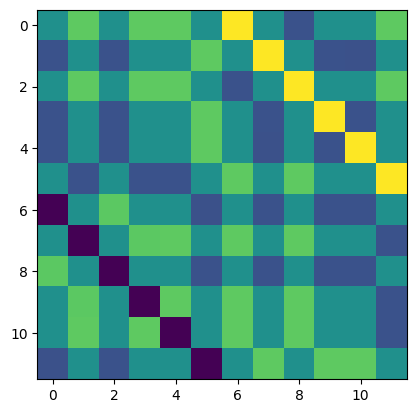

In [511]:
plt.imshow(Gamma1)

In [543]:
new_G=Gamma_n1(np.array([1,1,1j]),n=1)

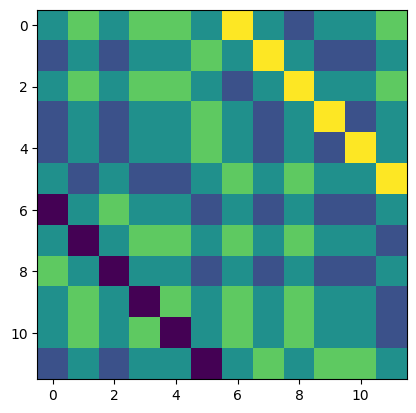

In [544]:
plt.imshow(new_G)

In [548]:
np.allclose(new_G,Gamma1)

True

In [563]:
vec=np.array([np.random.rand() for i in range(200)])
np.allclose(Gamma_n1_old(form_basis(vec),n=1),Gamma_n1(vec,n=1))

True

In [565]:
z=Gamma_n1_old(form_basis(vec),n=1)

In [567]:
zz=Gamma_n1(vec,n=1)

In [512]:
uu, vv = u[0],u[1:]

In [514]:
uu, vv = u[0],u[1:][::-1]

In [501]:
def RR(uu):
    if len(uu.shape)==1:
        uu=uu.reshape((1,-1))
    z= np.zeros((2*uu.shape[0],2*uu.shape[1]))
    z[::2,::2]=uu.real
    z[1::2,1::2]=uu.real
    z[::2,1::2]=-uu.imag
    z[1::2,::2]=uu.imag
    return z

In [502]:
uu

array([-0.57735027+0.j, -0.57735027-0.j, -0.57735027-0.j])

In [517]:
RR(uu).T.conj() @ np.array([[0,1],[-1,0]]) @ RR(uu) - Gamma1[:6,:6]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [529]:
S = np.array([[1,1j],[1,-1j]])

In [530]:
S.T.conj() @ uu.conj().T @ S @ np.array([[0,1],[-1,0]]) @ S.T.conj() @ uu @ S 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [527]:
(RR(np.eye(3)-(np.outer(uu.conj(),uu))) - Gamma1[:6,6:])

array([[ 1.11022302e-16, -0.00000000e+00, -1.11022302e-16,
        -0.00000000e+00,  0.00000000e+00, -5.55111512e-17],
       [ 0.00000000e+00,  1.11022302e-16,  0.00000000e+00,
        -1.11022302e-16,  5.55111512e-17,  0.00000000e+00],
       [-1.11022302e-16, -0.00000000e+00,  2.22044605e-16,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.11022302e-16,  0.00000000e+00,
         2.22044605e-16,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.55111512e-17,  0.00000000e+00,
         0.00000000e+00,  1.11022302e-16, -0.00000000e+00],
       [-5.55111512e-17,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.11022302e-16]])

In [533]:
1/2 *S.T.conj() @ np.array([[0,1],[-1,0]]) @ S

array([[0.+0.j, 0.-1.j],
       [0.-1.j, 0.+0.j]])

In [521]:
RR(vv).T.conj() @ RR(vv)  - Gamma1[:6,6:]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [515]:
RR(vv).T.conj() @ RR(vv)

array([[ 0.66666667,  0.        , -0.33333333,  0.        ,  0.        ,
         0.33333333],
       [ 0.        ,  0.66666667,  0.        , -0.33333333, -0.33333333,
         0.        ],
       [-0.33333333,  0.        ,  0.66666667,  0.        ,  0.        ,
         0.33333333],
       [ 0.        , -0.33333333,  0.        ,  0.66666667, -0.33333333,
         0.        ],
       [ 0.        , -0.33333333,  0.        , -0.33333333,  0.66666667,
         0.        ],
       [ 0.33333333,  0.        ,  0.33333333,  0.        ,  0.        ,
         0.66666667]])

In [180]:
np.take(np.array([[1,2],[3,4]]),[0,2])

array([1, 3])

In [ ]:
%lprun -f P_contraction_2 measure_feedback_layer()

In [168]:
nu_list[-1]

-1.875318711484329

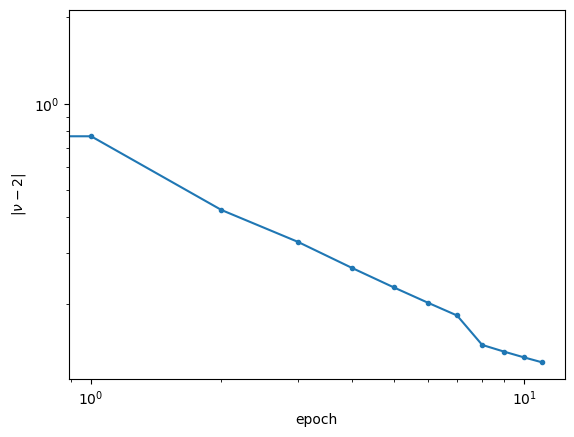

In [167]:
fig,ax=plt.subplots()
ax.plot(np.arange(len(nu_list)),np.array(nu_list)+2,'.-')
# ax.set_xlabel('steps')
ax.set_xlabel('epoch')
ax.set_ylabel(r'$|{\nu}-2|$')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-2,None)

In [55]:
gtn2.measure_Wannier_Born(ij=(0,0),lower=True)

0.5093166532047044


(array([ 2.90234818e-02+2.90234818e-02j, -5.83737686e-02+0.00000000e+00j,
         2.16888192e-19+1.66490915e-01j, -1.16747537e-01-2.12461903e-19j,
        -2.90234818e-02+2.90234818e-02j, -5.83737686e-02-5.62445555e-18j,
         1.66490915e-01+0.00000000e+00j, -1.16747537e-01+0.00000000e+00j,
         8.67552769e-19+0.00000000e+00j,  7.45584579e-01+0.00000000e+00j,
        -1.66490915e-01-2.81222777e-18j, -1.16747537e-01+0.00000000e+00j,
         2.90234818e-02-2.90234818e-02j, -5.83737686e-02+5.62445555e-18j,
         4.73612991e-19-1.66490915e-01j, -1.16747537e-01+2.12461903e-19j,
        -2.90234818e-02-2.90234818e-02j, -5.83737686e-02+0.00000000e+00j]),
 0)

In [51]:
gtn2.measure_single_mode_Born([0,1],mode=[1])

0.5109263521361453


([1], 0)

In [437]:
with open('C_m.pickle','rb') as f:
    C_m=pickle.load(f)
gtn2.C_m=C_m
gtn2.C_m_history[0]=C_m.copy()

In [ ]:
# op=gtn2.op_Wannier(n=1,lower=True)
op=gtn2.op_Wannier(n=0,lower=False)
plt.imshow(op)
for i in range(1,6):
    plt.axvline(i*4-0.5,color='r',lw=0.5)
    plt.axhline(i*4-0.5,color='r',lw=0.5)
plt.colorbar()

In [ ]:
op=gtn2.op_Wannier(n=1,lower=True)
# op=gtn2.op_Wannier(n=0,lower=False)
plt.imshow(op)
for i in range(1,6):
    plt.axvline(i*4-0.5,color='r',lw=0.5)
    plt.axhline(i*4-0.5,color='r',lw=0.5)
plt.colorbar()

In [600]:
for _ in (range(4)):
    ij_list = [(i,j) for i in range(gtn2.Lx) for j in range(gtn2.Ly)]
    for i,j in tqdm(ij_list):
        gtn2.measure_Wannier(ij=[i,j],n=1,lower=True)
        gtn2.measure_Wannier(ij=[i,j],n=0,lower=False)

100%|██████████| 144/144 [01:28<00:00,  1.63it/s]


In [43]:
6*6*2*2*2

288

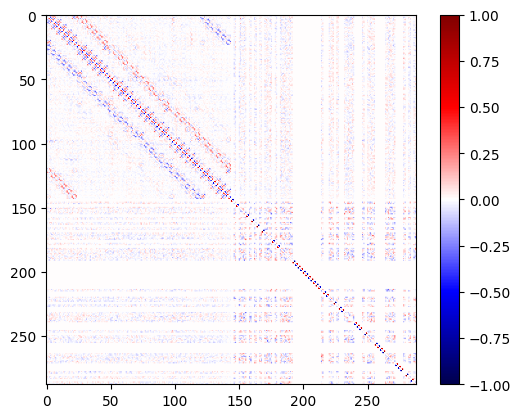

In [143]:
plt.imshow(gtn2.C_m_history[-1],cmap='seismic',vmin=-1,vmax=1)
# plt.imshow(gtn2.C_m,cmap='seismic',vmin=-1,vmax=1)
# plt.imshow(gtn2.C_m_history[2])
# for i in range(1,gtn2.Ly):
#     plt.axvline(4*i*gtn2.Lx-0.5,color='r',lw=0.5)
#     plt.axhline(4*i*gtn2.Lx-0.5,color='r',lw=0.5)

# for i in range(1,6):
#     plt.axvline(i*4-0.5,color='r',lw=0.5)
#     plt.axhline(i*4-0.5,color='r',lw=0.5)
plt.colorbar()

In [270]:
wf = np.stack([(a,b) for a,b in zip(gtn2.a_i.values(),gtn2.b_i.values())]).flatten()
u=form_basis(wf)

In [ ]:
u.T.conj()@u

In [47]:
nu_list=[chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)]
for _ in tqdm(range(2*gtn2.Lx)):
    ij_list = [(i,j) for i in range(gtn2.Lx) for j in range(gtn2.Ly)]
    for i,j in (ij_list):
        # gtn2.measure_tri_sites(A=0.5,Amu=0.5,ij=[i,j])
        gtn2.measure_tri_sites(A=0.5,Amu=0.99,ij=[i,j])
    nu_list.append(chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0))

100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


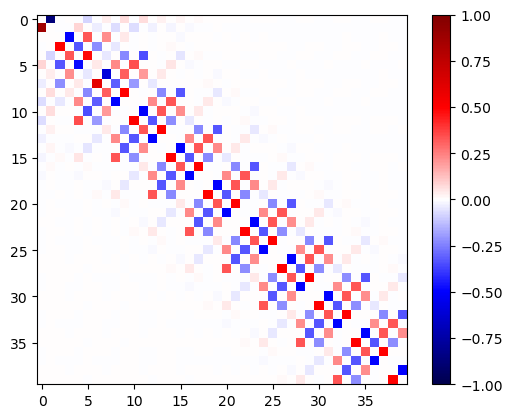

In [35]:
plt.imshow(gtn2.C_m_history[-1][:40,:40],vmin=-1,vmax=1,cmap='seismic')
plt.colorbar()

In [145]:
A_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in A_idx_0])
B_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in B_idx_0])
C_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in C_idx_0])

Text(0, 0.5, '$j$')

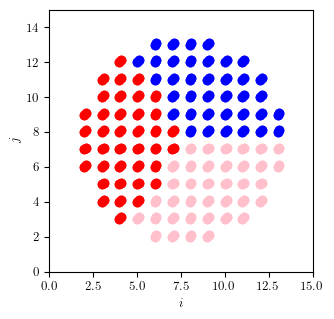

In [149]:
fig,ax=plt.subplots(figsize=(3.4,3.4))
ax.scatter(A_de_idx[:,0]+0.1*A_de_idx[:,2],A_de_idx[:,1]+0.1*A_de_idx[:,2],color='b')
ax.scatter(B_de_idx[:,0]+0.1*B_de_idx[:,2],B_de_idx[:,1]+0.1*B_de_idx[:,2],color='r')
ax.scatter(C_de_idx[:,0]+0.1*C_de_idx[:,2],C_de_idx[:,1]+0.1*C_de_idx[:,2],color='pink')
ax.set_xlim(0,gtn2.Lx)
ax.set_ylim(0,gtn2.Ly)
ax.set_xlabel('$i$')
ax.set_ylabel('$j$')

In [16]:
chern_number_quick(gtn2.C_m_history[-1],A_idx_0,B_idx_0,C_idx_0)
# chern_number_quick(C_m,A_idx_0,B_idx_0,C_idx_0)

-1.790734862826549

(-2.0, 0.24958610906276366)

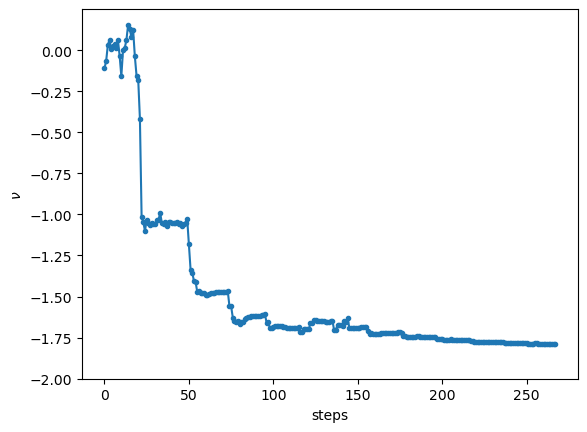

In [18]:
nu_list = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history[::10]]
plt.plot(nu_list,'.-')

plt.xlabel('steps')
plt.ylabel(r'$\nu$')
# plt.yticks(-2,0)
plt.ylim(-2,None)

In [ ]:
with open('gtn2.pickle','wb') as f:
    pickle.dump([gtn2.C_m_history,gtn2.n_history,gtn2.i_history],f)

Text(0, 0.5, '$\\nu$')

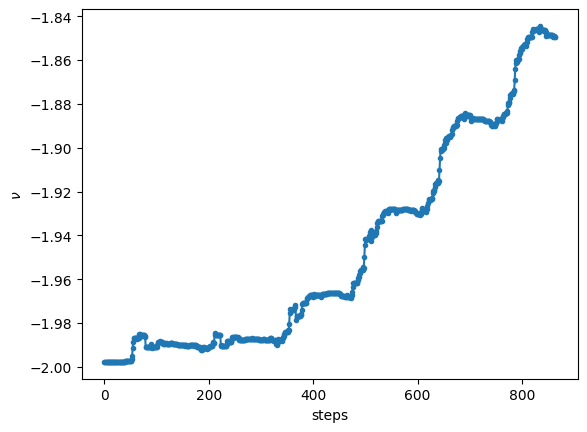

In [415]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

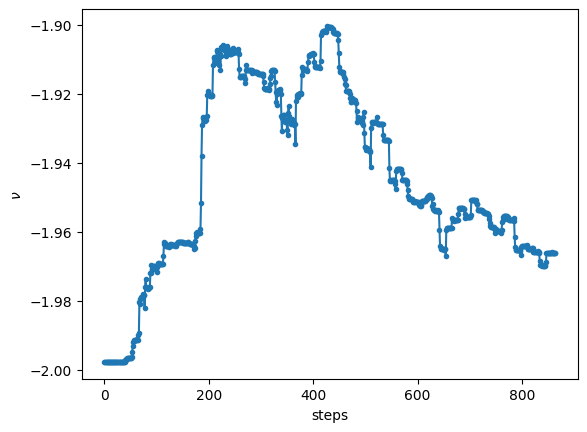

In [420]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

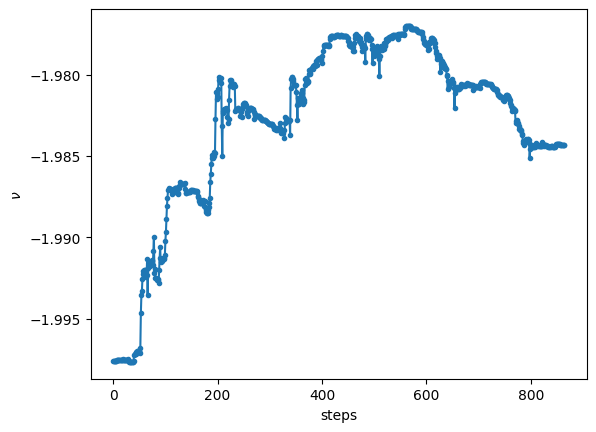

In [425]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

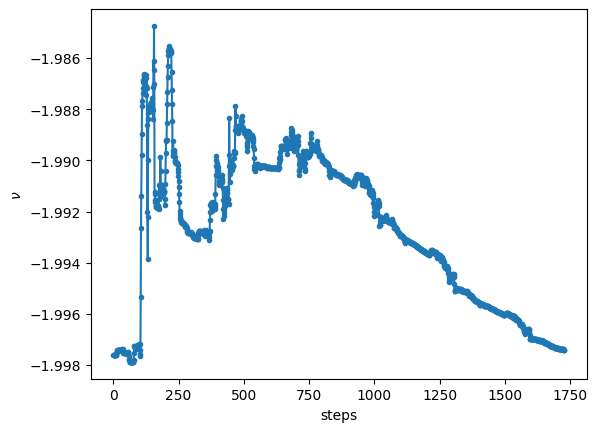

In [442]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

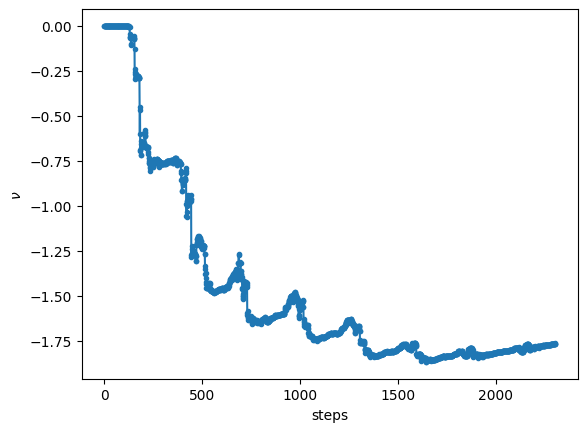

In [451]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

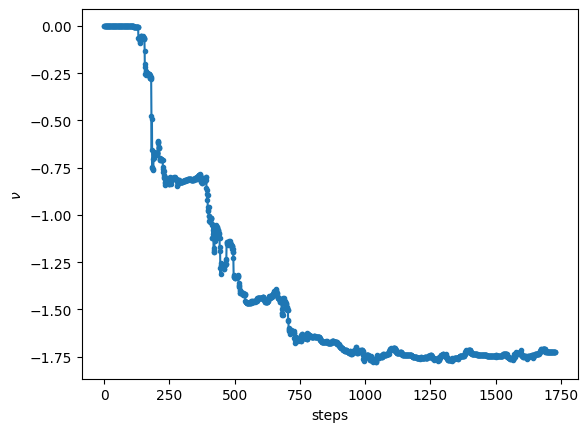

In [458]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

Text(0, 0.5, '$\\nu$')

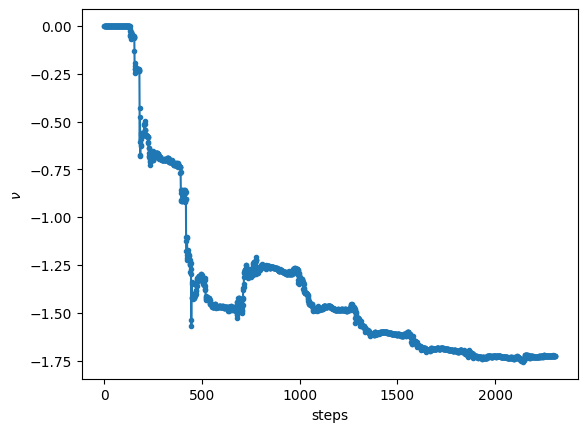

In [601]:
plt.plot([chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history],'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

In [204]:
r0 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [273]:
r_ = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [208]:
r1 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [216]:
r2 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

In [223]:
r3 = [chern_number_quick(x,A_idx_0,B_idx_0,C_idx_0) for x in gtn2.C_m_history]

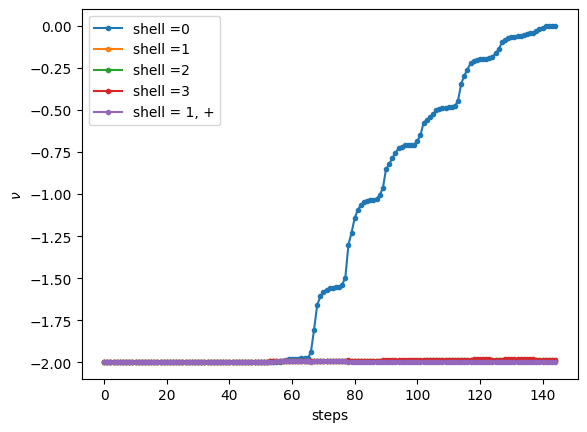

In [274]:
for idx,r in enumerate([r0,r1,r2,r3]):
    plt.plot(r,'.-',label=f'shell ={idx}')
plt.plot(r_,'.-',label='shell = 1, +')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')
plt.legend()

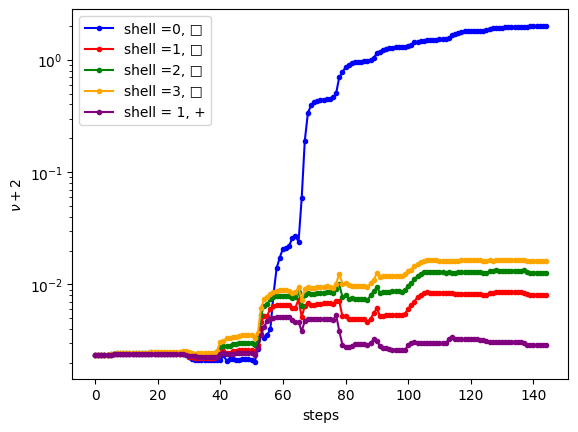

In [282]:
color_list = iter(['b','r','g','orange','purple'])
for idx,r in enumerate([r0,r1,r2,r3]):
    plt.plot(np.array(r)+2,'.-',label=f'shell ={idx}, □',color=next(color_list))
plt.plot(np.array(r_)+2,'.-',label='shell = 1, +',color=next(color_list))
plt.xlabel('steps')
plt.ylabel(r'$\nu+2$')
plt.yscale('log')
plt.legend()

Text(0, 0.5, '$\\nu$')

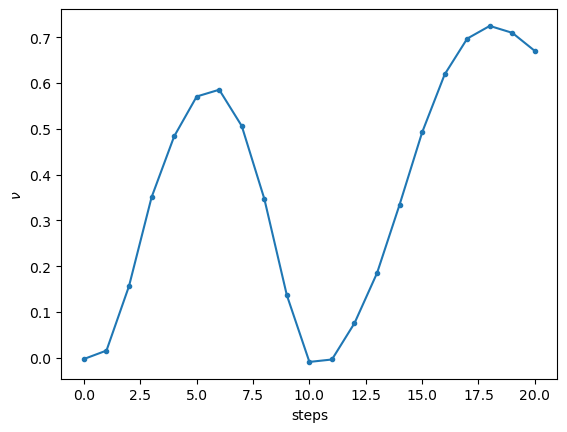

In [51]:
plt.plot(nu_list,'.-')
plt.xlabel('steps')
plt.ylabel(r'$\nu$')

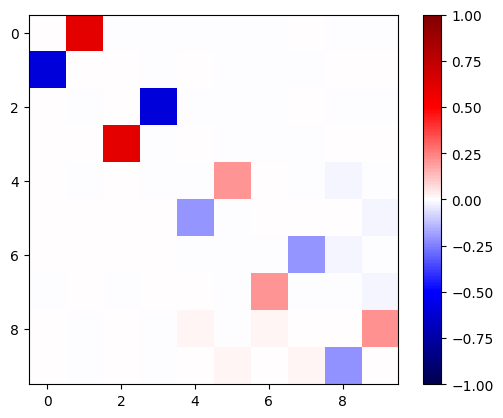

In [104]:
plt.imshow(gtn2.C_m[:10,:10],vmin=-1,vmax=1,cmap='seismic')
plt.colorbar()

In [98]:
C_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//2,gtn2.Lx),np.arange(gtn2.Ly))

In [102]:
gtn2.von_Neumann_entropy_m(C_idx_0,fermion_idx=False)

14.779519209094035

In [83]:
ec=gtn2.entanglement_contour(C_idx_0,fermion_idx=False)

In [76]:
C_de_idx=np.array([gtn2.delinearize_idx(idx) for idx in C_idx_0])


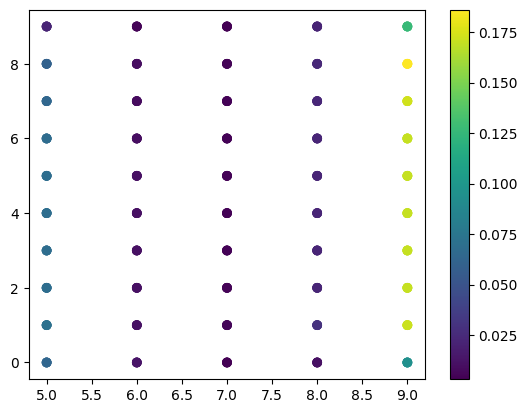

In [58]:
plt.scatter(C_de_idx[:,0],C_de_idx[:,1],c=ec)
plt.colorbar()

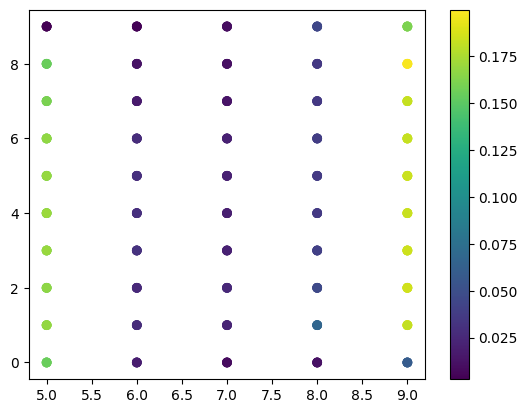

In [103]:
plt.scatter(C_de_idx[:,0],C_de_idx[:,1],c=ec)
plt.colorbar()

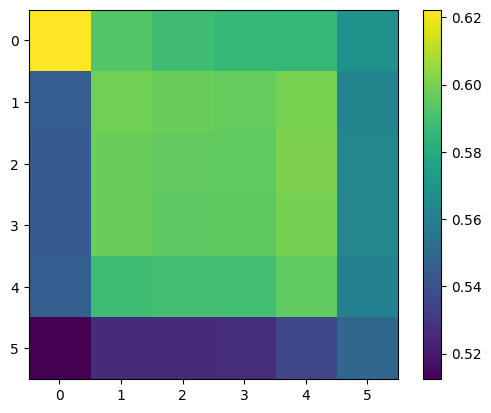

In [503]:
plt.imshow((1/2-np.diag(gtn2.C_m,k=1)[::2]/2).reshape((gtn2.Lx,gtn2.Ly,2))[:,:,1])
plt.colorbar()

In [12]:
A_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//4,gtn2.Lx//2),np.arange(gtn2.Ly//4,gtn2.Ly//2))
B_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//4,gtn2.Lx//2),np.arange(gtn2.Ly//2,gtn2.Ly//4*3))
C_idx_0=gtn2.linearize_idx_span(np.arange(gtn2.Lx//2,gtn2.Lx//4*3),np.arange(gtn2.Ly//4,gtn2.Ly//4*3))

In [14]:
chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0)

-1.6731606887940065

In [474]:
A_idx=gtn2.linearize_idx_span(range(gtn2.Lx//2),range(gtn2.Ly//2))

In [475]:
B_idx=gtn2.linearize_idx_span(range(gtn2.Lx//2,gtn2.Lx),range(gtn2.Ly//2))

In [476]:
C_idx=gtn2.linearize_idx_span(range(gtn2.Lx),range(gtn2.Ly//2,gtn2.Ly))

In [ ]:
gtn2.linearize_idx_span([0,1],[0,1])

array([ 0,  1,  2,  3,  4,  5,  6,  7, 20, 21, 22, 23, 24, 25, 26, 27])

In [481]:
P=(np.eye(gtn2.C_m.shape[0])-1j*gtn2.C_m)/2

In [452]:
from opt_einsum import contract

In [482]:
h=12*np.pi*1j*(contract("jk,kl,lj->jkl",P,P,P)-contract("jl,lk,kj->jkl",P,P,P))

In [486]:
h[np.ix_(A_idx,B_idx,C_idx)].sum()

(-5.873079800267078e-14+0j)

In [488]:
chern_number(gtn2.C_m,A_idx,B_idx,C_idx)

(-5.873079800267078e-14+0j)

In [458]:
gtn2.linearize_idx(i=0,j=1,orbit_idx=0,majorana=0)  

4

In [462]:
np.ravel_multi_index([[0,1],[0,1]],[5,5])

array([0, 6])

In [441]:
np.max(np.abs(P.T.conj()-P))

1.249000902703301e-16

In [443]:
np.max(np.abs(P@P-P))

2.886579864025407e-14

In [450]:
np.max(np.abs(P.T.conj()@P-P))

2.886579872166139e-14

In [421]:
p=gtn2.C_m

array([[ 1.02290150e-17,  2.12627086e-01,  9.59583208e-03, ...,
        -2.39034291e-02,  4.23823023e-03, -3.98507131e-02],
       [-2.12627086e-01, -6.90892406e-18, -1.03912934e-01, ...,
         1.31669302e-02, -1.32222135e-02,  3.51792143e-03],
       [-9.59583208e-03,  1.03912934e-01,  4.33579278e-18, ...,
         3.15582823e-02, -1.39048758e-02,  3.85001289e-02],
       ...,
       [ 2.39034291e-02, -1.31669302e-02, -3.15582823e-02, ...,
        -6.73966481e-18, -8.45147817e-04, -1.38972953e-03],
       [-4.23823023e-03,  1.32222135e-02,  1.39048758e-02, ...,
         8.45147817e-04, -4.75642556e-19, -6.59453835e-01],
       [ 3.98507131e-02, -3.51792143e-03, -3.85001289e-02, ...,
         1.38972953e-03,  6.59453835e-01,  4.76738986e-19]])

In [ ]:
even start from stead state?
random start to project to avoid even-odd effect?
Kitaev's topological invariant


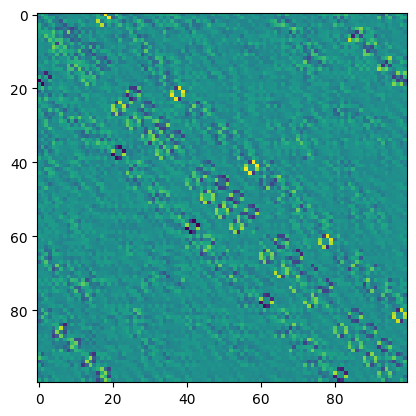

In [156]:
plt.imshow(gtn2.C_m)

In [21]:
gtn2.measure_weak(0.9,[0,1],'onsite')
gtn2.measure_weak(-0.9,[2,3],'onsite')

In [240]:
for t in range(gtn2.Ly*gtn2.Lx):
    for ly in range(gtn2.Ly):
        gtn2.measure_line_tri_op(p_list=0.5,pos=(ly,-1),even=True)
        gtn2.measure_line_tri_op(p_list=1-0.5,pos=(ly,-1),even=False)

In [ ]:
gtn2.C_m

In [196]:
gtn2.C_m[:4,:4]

array([[ 0.        ,  0.9850454 ,  0.17229498,  0.        ],
       [-0.9850454 ,  0.        ,  0.        ,  0.        ],
       [-0.17229498,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [190]:
gtn2.von_Neumann_entropy_m(np.arange(gtn2.L//2))

2.1442952223724603e-15

In [107]:
gtn2.measure_line_tri_op(p_list=0.5,pos=(-1,1),even=False)

([3, 11, 19], [10, 18, 26])

In [39]:
gtn2.linearize_idx(1,0,0)

8

In [42]:
gtn2.delinearize_idx(10)

((1, 1), 0)

In [6]:
gtn2.measure_tri_op(0,1,p=1)

In [40]:
gtn2.history

True

In [48]:
gtn2.n_history

[array([0.        , 0.98804366, 0.15417434])]

# ED of local Ham

In [6]:
import numpy as np

In [7]:
numpy.__version__

'1.24.0'

In [8]:
from quspin.basis import spin_basis_general

In [38]:
L = 6
sites = np.arange(L)

In [39]:
basis = spin_basis_general(
    L,
)

In [ ]:
print(basis)

In [1]:
from quspin.basis import spinless_fermion_basis_1d

In [2]:
from quspin.operators import hamiltonian, exp_op

In [45]:
L = 10  # system size
J = 1.0  # uniform hopping
deltaJ = 0.1  # bond dimerisation
Delta = 0.5  # staggered potential
# beta = 100.0  # inverse temperature for Fermi-Dirac distribution
##### construct single-particle Hamiltonian #####
# define site-coupling lists
hop_pm = [[-J - deltaJ * (-1) ** i, i, (i + 1) % L] for i in range(L)]  # PBC
hop_mp = [[+J + deltaJ * (-1) ** i, i, (i + 1) % L] for i in range(L)]  # PBC
stagg_pot = [[Delta * (-1) ** i, i] for i in range(L)]
# define static and dynamic lists
static = [["+-", hop_pm], ["-+", hop_mp], ["n", stagg_pot]]
dynamic = []
# define basis
basis = spinless_fermion_basis_1d(L, Nf=1)
# build real-space Hamiltonian
H = hamiltonian(static, dynamic, basis=basis, dtype=np.float64)
# diagonalise real-space Hamiltonian
E, V = H.eigh()

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [68]:
import numpy as np

In [79]:
L=6
basis = spinless_fermion_basis_1d(L, Nf=4)


In [80]:
basis.Ns

15

In [18]:
mu=1
t=1
Delta=1

In [19]:
onsite = [[-mu,i] for i in range(0,6,2)] + [[mu,i] for i in range(1,6,2)]
LL = [[-t,0,2],[-t,0,4],[-t,2,0],[-t,4,0]]
RR = [[t,1,3],[t,1,5],[t,3,1],[t,5,1]]
LR = [[Delta,0,3],[-Delta,1,2],[-1j*Delta,0,5],[-1j*Delta,1,4],[Delta,3,0],[-Delta,2,1],[1j*Delta,5,0],[1j*Delta,4,1]]
# xR
# xLR
# xRL

static=[["n", onsite],["+-",LL],["+-",RR],["+-",LR]]
dynamic=[]

In [61]:
basis=spinless_fermion_basis_1d(L, Nf=1)

In [62]:
H=hamiltonian(static, dynamic, basis=basis, )

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [63]:
H.todense()

matrix([[-1.+0.j,  0.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  0.-1.j],
        [ 0.+0.j,  1.+0.j, -1.+0.j,  1.+0.j,  0.-1.j,  1.+0.j],
        [-1.+0.j, -1.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 1.+0.j,  1.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
        [-1.+0.j,  0.+1.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
        [ 0.+1.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

In [64]:
E, V = H.eigh()

In [65]:
E

array([-2.97839968, -1.4404177 , -0.23309265,  0.23309265,  1.4404177 ,
        2.97839968])

In [58]:
E

array([-2.97839968, -1.4404177 , -0.23309265,  0.23309265,  1.4404177 ,
        2.97839968])

In [66]:
V[:,0]

array([ 0.65407316-0.j        ,  0.20083574+0.20083574j,
        0.43212143+0.10151424j, -0.21488764-0.05048154j,
        0.43212143-0.10151424j, -0.05048154-0.21488764j])

In [70]:
np.abs(V[:,0])**2

array([0.4278117 , 0.08066999, 0.19703407, 0.04872508, 0.19703407,
       0.04872508])

In [71]:
np.abs(V[:,1])**2

array([0.08528068, 0.14368696, 0.37335642, 0.01215976, 0.37335642,
       0.01215976])

In [72]:
np.abs(V[:,2])**2

array([0.23896356, 0.02358711, 0.26588029, 0.10284437, 0.26588029,
       0.10284437])

In [73]:
np.abs(V[:,3])**2

array([0.02358711, 0.23896356, 0.10284437, 0.26588029, 0.10284437,
       0.26588029])

In [60]:
basis.states

array([62, 61, 59, 55, 47, 31], dtype=uint32)

In [44]:
basis.int_to_state(62)

'|1 1 1 1 1 0>'

In [ ]:
basis.

In [75]:
[basis.int_to_state(basis.states[1]) ]

'|1 0 1 0 0 0>'

In [50]:
import matplotlib.pyplot as plt

In [55]:
(H.as_dense_format())

(10, 10)

In [12]:
states = (
    basis.states
)

In [17]:
array_inds = np.arange(
    basis.Ns
)

In [18]:
array_inds

array([0, 1, 2, 3])

In [19]:
print("\n'array index' and 'states' columns when printing the basis:")
print("array indices:", array_inds)
print("states in int rep:", states)


'array index' and 'states' columns when printing the basis:
array indices: [0 1 2 3]
states in int rep: [3 2 1 0]


In [20]:
s = basis.states[2]
array_ind_s = basis.index(
    s
) 

In [22]:
print(
    "\nprint array index of s, and s (in int rep); Note: the array index is crucial for reading-off matrix elements"
)
print(array_ind_s, s)



print array index of s, and s (in int rep); Note: the array index is crucial for reading-off matrix elements
2 1


In [34]:
fock_state_str_s = "|00>"  # works also if the ket-forming strings | > are omitted
int_rep_s = basis.state_to_int(fock_state_str_s)
print("\nprint Fock state string of s, and s (in int rep):")
print(fock_state_str_s, int_rep_s)


print Fock state string of s, and s (in int rep):
|00> 0


In [35]:
fock_s = basis.int_to_state(int_rep_s, bracket_notation=True)
print("\nprint Fock state string of s, and s (in int rep):")
print(fock_s, int_rep_s)


print Fock state string of s, and s (in int rep):
|0 0> 0


In [36]:
fock_s = basis.int_to_state(int_rep_s, bracket_notation=False)
print("print Fock state string (without | and >) of s, and s (in int rep):")
print(fock_s, int_rep_s)

print Fock state string (without | and >) of s, and s (in int rep):
00 0


In [37]:
array_ind_s = 2
int_rep_s = basis.states[array_ind_s]
fock_s = basis.int_to_state(int_rep_s, bracket_notation=True)
print("\nprint array index, int rep, and fock state rep of s:")
print(array_ind_s, int_rep_s, fock_s)  # compare with print(basis) output
# 


print array index, int rep, and fock state rep of s:
2 1 |0 1>
